This notebook contains the final code used to generate figures and analyses.

All main results will be focused on autosomes, with X chromosome analysis presented separately.

## Setup and Imports

In [ ]:
import gzip
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
# set font to helvetica for the manuscript
import matplotlib as mpl
from matplotlib import pyplot
# use custom file with helvetica as default
import matplotlib.font_manager as fm
font_path = "/wynton/home/capra/ychen39/.local/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/Helvetica.ttf"
fm.fontManager.addfont(font_path)
mpl.rcParams['font.family'] = 'Helvetica'
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'
import seaborn as sns
sns.set_theme(font='Helvetica')
import pyranges as pr
import pyBigWig
import os
import pybedtools
BEDTOOLSDIR = '/wynton/home/cbi/shared/software/CBI/bedtools2-2.31.1/bin'
pybedtools.helpers.set_bedtools_path(path=f'{BEDTOOLSDIR}')
import tarfile
import io
import sklearn
from sklearn.preprocessing import LabelEncoder
import re
import upsetplot
from upsetplot import UpSet, from_indicators, plot
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from collections import defaultdict
import itertools
import joypy
from pathlib import Path
from scipy import stats
from scipy.stats import mannwhitneyu
import pickle

# change parent directory to use tools
os.chdir(Path.cwd().parent)
from introgression_tools import tools


HOMEDIR='/wynton/home/capra/ychen39/'

# renaming dict
rename_dict = {'ibdmix': 'IBDMix', 'argweaverd': 'ARGweaver-D', 'archaicseeker': 'ArchaicSeeker2', 'archie': 'ArchIE',
                                   'sprime': 'Sprime', 'sarge': 'SARGE', 'vernot_2016':'S*', 'sankararaman_2014': 'Sankararaman14',
                                 'sankararaman_2016_1':'Sankararaman16 (1)', 'sankararaman_2016_2':'Sankararaman16 (2)', 'skov_2020':'Skov20',
                                 'steinruecken_2018':'DICAL-ADMIX', 'vernot_2016_extendedLD': 'S* (extended LD)', 
                                 'vernot_2016_medianextendedLD': 'S* (median extended LD)'}

rename_dict_dir = {'chen_2020': 'IBDMix', 'hubisz_2020': 'ARGweaver-D', 'yuan_2021': 'ArchaicSeeker2', 'durvasula_2019': 'ArchIE',
                                   'browning_2018': 'Sprime', 'schaefer_2021': 'SARGE', 'vernot_2016':'S*', 'sankararaman_2014': 'Sankararaman14',
                                 'sankararaman_2016_1':'Sankararaman16 (1)', 'sankararaman_2016_2':'Sankararaman16 (2)', 'skov_2020':'Skov20',
                                 'steinruecken_2018':'DICAL-ADMIX'}

methods_dirs = ['chen_2020', 'yuan_2021', 'durvasula_2019', 'steinruecken_2018', 'skov_2020', 'schaefer_2021', 'hubisz_2020', 'browning_2018', 'vernot_2016', 'sankararaman_2014', 'sankararaman_2016_1', 'sankararaman_2016_2']

coverage_dict = {'IBDMix': 0.47890883152724967,
 'ArchaicSeeker2': 0.5706709907769207,
 'ArchIE': 0.27194071376151385,
 'DICAL-ADMIX': 0.36043673757944056,
 'Skov20': 0.31329610913934747,
 'SARGE': 0.39741827365017096,
 'ARGweaver-D': 0.04809670667100604,
 'Sprime': 0.463172077576961,
 'S*': 0.49896038315855085,
 'Sankararaman14': 0.3855405095493459,
 'Sankararaman16 (1)': 0.5397360584221831,
 'Sankararaman16 (2)': 0.39352200593195485} # computed below

## Checking versions

In [89]:
from importlib.metadata import version
version('matplotlib')

'3.9.2'

In [8]:
import sys
print(sys.version)


3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]


## Basic descriptive stats:

#### Calculate coverage of introgression maps across the genome (hg19, gaps removed)

In [ ]:
# make bed file of the hg19 genome
!awk 'BEGIN {OFS="\t"} {print $1, "0", $2}' {HOMEDIR}/introgression_methods/data/sorted_hg19.fa.fai > {HOMEDIR}/introgression_methods/data/human_hg19.bed
# subtract gaps
!{BEDTOOLSDIR}/bedtools subtract -a {HOMEDIR}/introgression_methods/data/human_hg19.bed -b {HOMEDIR}/introgression_methods/data/hg19_gaps.txt > /wynton/home/capra/ychen39/introgression_methods/data/human_hg19_gaps_removed.bed

In [ ]:
# coverage of the genome
hg19_no_gaps=pd.read_csv(f'{HOMEDIR}/introgression_methods/data/human_hg19_gaps_removed.bed', sep='\t', names=['chrom', 'start', 'end'])
# compute length
hg19_no_gaps['length']=hg19_no_gaps.end-hg19_no_gaps.start
# genome length value
genome_length=np.sum(hg19_no_gaps.length)

# read in overlap file containing all introgressed regions across maps (columns)
boolean_overlap = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap.bed', sep='\t', low_memory=False)
# print denominator, and overall introgression map-wide coverage across all maps
print(boolean_overlap.length.sum(), " bases", boolean_overlap.length.sum()/genome_length*100, "%")

2242601207  bases 77.40270998946222 %


In [ ]:
# compute coverage across methods
coverage_dict = {} # empty dictionary to hold values

# read in method-specific introgression map
for method in methods_dirs:
    df = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', sep='\t', names=['chrom', 'start', 'end', 'score'])
    df['length']=df.end-df.start
    coverage = tools.bed_overall_proportion(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', 
                       f'{HOMEDIR}/introgression_methods/data/human_hg19_gaps_removed.bed',
                       f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/introgression_coverage.bed')# add length data
    method_name = rename_dict_dir[f'{method}']
    # add lengths to a dictionary
    coverage_dict[method_name]=coverage*100

coverage_dict

2684578480
2684578480
2684578480
2835679040
2835679040
2684578480
2835679040
2684578480
2684578480
2835679040
2835679040
2835679040


{'IBDMix': 47.89088315272497,
 'ArchaicSeeker2': 57.06709907769208,
 'ArchIE': 27.194071376151385,
 'DICAL-ADMIX': 36.043673757944056,
 'Skov20': 31.329610913934747,
 'SARGE': 39.741827365017095,
 'ARGweaver-D': 4.809670667100604,
 'Sprime': 46.317207757696096,
 'S*': 49.89603831585509,
 'Sankararaman14': 38.55405095493459,
 'Sankararaman16 (1)': 53.973605842218305,
 'Sankararaman16 (2)': 39.352200593195484}

In [ ]:
# compute coverage across methods - raw base pairs
bps_dict = {}

for method in methods_dirs:
    df = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', sep='\t', names=['chrom', 'start', 'end', 'score'])
    df['length']=df.end-df.start
    coverage=np.sum(df.length)
    method_name = rename_dict_dir[f'{method}']
    # add lengths to a dictionary
    bps_dict[method_name]=coverage

bps_dict

{'IBDMix': 1291413343,
 'ArchaicSeeker2': 1534838051,
 'ArchIE': 730500000,
 'DICAL-ADMIX': 1023339000,
 'Skov20': 889069710,
 'SARGE': 1068860156,
 'ARGweaver-D': 136667575,
 'Sprime': 1243444992,
 'S*': 1339505007,
 'Sankararaman14': 1117531142,
 'Sankararaman16 (1)': 1558018928,
 'Sankararaman16 (2)': 1141804104}

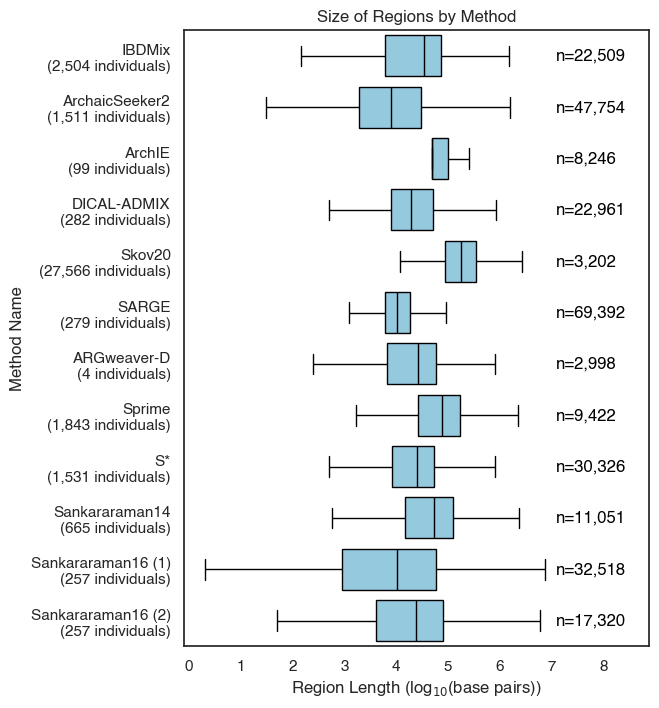

In [ ]:
# create box plot, first make dictionary with method name and lengths across the genome of introgression deserts 
lengths_dict = {}
num_regions_dict = {}

# use Helvetica
sns.set_theme(style="white", rc={"font.family": "Helvetica", "font.size": 14})

# add method names and the # people the maps are based on
rename_dict_dir_n = {'chen_2020': 'IBDMix\n(2,504 individuals)', 'hubisz_2020': 'ARGweaver-D\n(4 individuals)', 'yuan_2021': 'ArchaicSeeker2\n(1,511 individuals)', 'durvasula_2019': 'ArchIE\n(99 individuals)',
                                   'browning_2018': 'Sprime\n(1,843 individuals)', 'schaefer_2021': 'SARGE\n(279 individuals)', 'vernot_2016':'S*\n(1,531 individuals)', 
                                   'sankararaman_2014': 'Sankararaman14\n(665 individuals)',
                                 'sankararaman_2016_1':'Sankararaman16 (1)\n(257 individuals)', 'sankararaman_2016_2':'Sankararaman16 (2)\n(257 individuals)', 'skov_2020':'Skov20\n(27,566 individuals)',
                                 'steinruecken_2018':'DICAL-ADMIX\n(282 individuals)'}

# for each method, compute total length
for method in methods_dirs:
    # get corresponding method name
    method_name = rename_dict_dir_n[method]
    df = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', sep='\t', names=['chrom', 'start', 'end'])
    # add length data
    df['length'] = df['end'] - df['start']
    # add lengths to a dictionary
    lengths_dict[f'{method_name}']=np.log10(df['length'])
    num_regions_dict[f'{method_name}']=len(df)

# flatten data and rename columns
flattened_data = [(key, value) for key, values in lengths_dict.items() for value in values]
lengths_df = pd.DataFrame(flattened_data)
lengths_df.rename(columns={0:'Method Name', 1:'Log10Length'}, inplace=True)

# box plot
plt.rcParams['font.size'] = 14
sns.set_theme(style="white", rc={"font.family": "Helvetica", "font.size": 14,'figure.figsize':(6,8)})
sns.boxplot(data=lengths_df, x='Log10Length', y='Method Name', showfliers=False, color='skyblue', 
            boxprops=dict(edgecolor='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    medianprops=dict(color='black'))
plt.title('Size of Regions by Method')
plt.xlabel(r'Region Length (log$_{10}$(base pairs))')

# overlay strip plot with jitter - took this out per Tony's comments
# sns.stripplot(data=lengths_df, x='Log10Length', y='Method Name', jitter=True, color='grey', size=2)

# add text for number of regions
for i, method in enumerate(lengths_df['Method Name'].unique()):
    num_regions = num_regions_dict[method]
    plt.text(lengths_df['Log10Length'].max() + 0.2, i, f"n={num_regions:,}", 
             ha='left', va='center', fontsize=12, color='black')

# plot limits
plt.xlim(left=lengths_df['Log10Length'].min() - 0.1, right=lengths_df['Log10Length'].max() + 2)

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/FigBPCountsB.svg', bbox_inches='tight')  

plt.show()

### X chromosome depletion: % of introgression in X chr vs. autosomes per method (with X introgression inference)

In [18]:
# compute coverage across methods for x and autosomes
x_introgression = {} 
autosome_introgression = {}

# get x and autosomes denominator (base pairs)
hg19_no_gaps=pd.read_csv(f'{HOMEDIR}/introgression_methods/data/human_hg19_gaps_removed.bed', sep='\t', names=['chrom', 'start', 'end'])
hg19_no_gaps['length']=hg19_no_gaps.end-hg19_no_gaps.start
x_length = np.sum(hg19_no_gaps[hg19_no_gaps['chrom']=='chrX'].length)
auto_length = np.sum(hg19_no_gaps[hg19_no_gaps['chrom']!='chrX'].length)

for method in methods_dirs:
    df = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', sep='\t', names=['chrom', 'start', 'end', 'score'])
    df['length']=df.end-df.start
    # subset df
    if 'chrX' in df['chrom'].unique():
        x_only = df[df['chrom']=='chrX']
        auto_only = df[df['chrom']!='chrX']
        # compute bps in each
        x_coverage = np.sum(x_only.length)
        auto_coverage = np.sum(auto_only.length)
        # rename method
        method_name = rename_dict_dir[f'{method}']
        # add lengths to a dictionary
        x_introgression[method_name]=x_coverage / x_length
        autosome_introgression[method_name]=auto_coverage / auto_length

{'DICAL-ADMIX': 0.11701809708713191,
 'Skov20': 0.051714341760215846,
 'ARGweaver-D': 0.007543128893764524,
 'Sankararaman14': 0.10934429362803155,
 'Sankararaman16 (1)': 0.22492411676038793,
 'Sankararaman16 (2)': 0.15068804510056086}

In [20]:
x_introgression

{'DICAL-ADMIX': 0.11701809708713191,
 'Skov20': 0.051714341760215846,
 'ARGweaver-D': 0.007543128893764524,
 'Sankararaman14': 0.10934429362803155,
 'Sankararaman16 (1)': 0.22492411676038793,
 'Sankararaman16 (2)': 0.15068804510056086}

In [19]:
autosome_introgression


{'DICAL-ADMIX': 0.36619758056233614,
 'Skov20': 0.32089820310563333,
 'ARGweaver-D': 0.04935075204403736,
 'Sankararaman14': 0.4009186923346914,
 'Sankararaman16 (1)': 0.5549574406190181,
 'Sankararaman16 (2)': 0.40748259727754066}

## Lengths distribution across methods

In [ ]:
# output is included in imports, but re-adding here

coverage_dict = {} # empty dictionary to hold values
# compute coverage across methods
for method in methods_dirs:
    coverage = tools.bed_overall_proportion(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/bedgraphs/union_merged_chr_prefix.bg', 
                       f'{HOMEDIR}/introgression_methods/data/human_hg19_gaps_removed.bed',
                       f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/introgression_coverage.bed')# add length data
    method_name = rename_dict_dir[f'{method}']
    # add lengths to a dictionary
    coverage_dict[method_name]=coverage

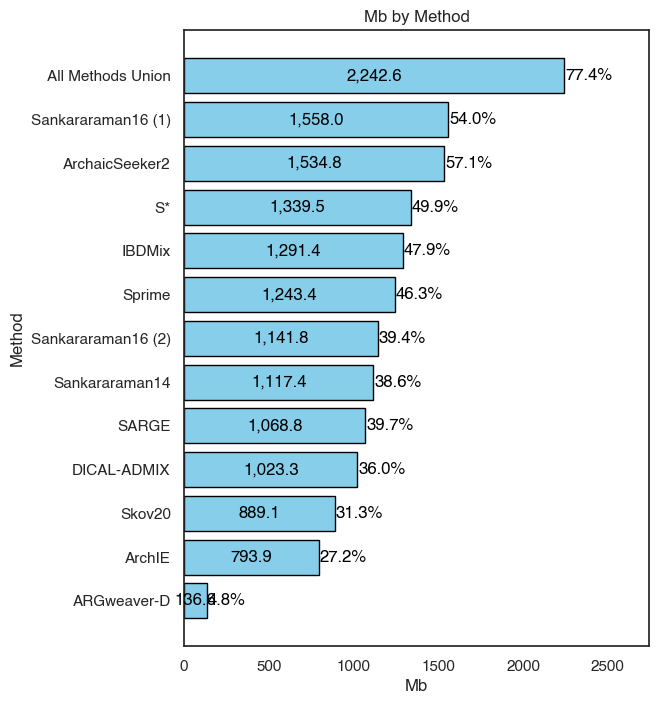

In [ ]:
# Bar plot of introgression amounts per map

# overlap file with all 12 methods
overlap = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/all_methods.bed', sep='\t', low_memory=False)
overlap = overlap.rename(columns=rename_dict)

# count the bases per map and make into a datafrmae
bp_count = overlap.drop(['chrom', 'start', 'end', 'length'], axis=1)

for column in bp_count.columns:
    bp_count.loc[bp_count[column].notnull(), column] = overlap['length']

bp_count_sum = pd.DataFrame(bp_count.sum()).reset_index()
bp_count_sum.columns=['Algorithm', 'Base Pairs']

bps_dict = pd.Series(bp_count_sum['Base Pairs'].values, index=bp_count_sum['Algorithm']).to_dict()

# manually add union of all methods
bps_dict['All Methods Union'] = overlap.length.sum()
coverage_dict['All Methods Union'] = 0.7740270998946222

# sort keys by descending value
sorted_keys = sorted(bps_dict, key=lambda k: bps_dict[k])
# get the bp counts (divided by 1 million, coverages, and num regions
bp_counts = [bps_dict[k]/1000000 for k in sorted_keys]
coverage_percentages = [coverage_dict[k]*100 for k in sorted_keys]

# bar plot
fig, ax = plt.subplots(figsize=(6, 8))
plt.rcParams['font.size'] = 14
bars = ax.barh(sorted_keys, bp_counts, color="skyblue", edgecolor="black")

# put millions of base pair counts inside bars
for bar, inside in zip(bars, bp_counts):
    ax.text(bar.get_width()/2, bar.get_y() + bar.get_height()/2, f"{inside:,.1f}",
            ha='center', va='center', fontsize=12, color="black")

# put coverage percentages outside bars
for bar, outside in zip(bars, coverage_percentages):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, f"{outside:.1f}%",
            ha='left', va='center', fontsize=12, color="black")

plt.title('Mb by Method')
plt.ylabel('Method')
plt.xlabel('Mb')
# plot limits
plt.xlim(0, right=np.max(bp_counts) + 500)

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/Fig1A.svg', bbox_inches='tight')  

plt.show()



## Unique BP (per method, upset plot)

### Unique BP per method - Whole Maps

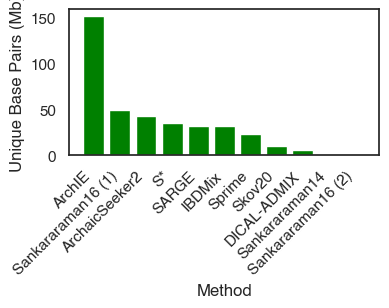

17.12219824821817


In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_no_argweaver = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_no_argweaver.bed', sep='\t', low_memory=False)
boolean_overlap_no_argweaver = boolean_overlap_no_argweaver.rename(columns=rename_dict)

# bar plot of unique values
# List to store the sum of lengths
length_sums = []

# get list of columns except 'length'
to_remove = ['chrom', 'start', 'end', 'length']
columns = list(boolean_overlap_no_argweaver.columns)
columns=[name for name in columns if name not in to_remove]

# initialize sums
total_sums = 0

for col in columns:
    # create mask for the current column being True and all others False
    filter_condition = (boolean_overlap_no_argweaver[col] == True)
    for other_col in columns:
        if other_col != col:
            filter_condition &= (boolean_overlap_no_argweaver[other_col] == False)
    
    # sum 'length' column over mask
    length_sum = boolean_overlap_no_argweaver[filter_condition]['length'].sum()/1000000
    # save unique length values
    length_sums.append((col, length_sum))
    total_sums += boolean_overlap_no_argweaver[filter_condition]['length'].sum()

# sort sums in descending order
length_sums.sort(key=lambda x: x[1], reverse=True)

# separate sorted column names and their sums
sorted_columns, sorted_sums = zip(*length_sums)

# bar plot
plt.figure(figsize=(4,2))
plt.bar(sorted_columns, sorted_sums, color='green')
plt.xlabel('Method')
plt.ylabel('Unique Base Pairs (Mb)')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/unique_base_pairs_plot_no_argweaver.svg', bbox_inches='tight')  

plt.show()

# print % num unique base pairs/total number of introgressed base pairs
print(total_sums/boolean_overlap_no_argweaver.length.sum()*100)

### Unique BP per method - Top 793.9 Mb

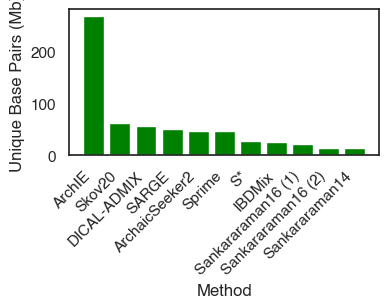

In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_size_matched = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores.bed', sep='\t', low_memory=False)
# list of columns to exclude to convert to voolean
exclude_columns = ['chrom', 'start', 'end', 'length']
# replace 0 as NA
boolean_overlap_size_matched.replace(0, np.nan, inplace=True)
# convert values to boolean values (true or false)
boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)] = boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)].apply(lambda x: pd.notna(x))
# calculate length
boolean_overlap_size_matched['length'] = boolean_overlap_size_matched['end'] - boolean_overlap_size_matched['start']
# rename algorithms
boolean_overlap_size_matched = boolean_overlap_size_matched.rename(columns=rename_dict)

# bar plot of unique values
# list to store sum of lengths
length_sums = []

# list of columns except 'length'
to_remove = ['chrom', 'start', 'end', 'length']
columns = list(boolean_overlap_size_matched.columns)
columns=[name for name in columns if name not in to_remove]

total_sums = 0

for col in columns:
    # create mask for the current column being True and all others False
    filter_condition = (boolean_overlap_size_matched[col] == True)
    for other_col in columns:
        if other_col != col:
            filter_condition &= (boolean_overlap_size_matched[other_col] == False)
    
    # sum 'length' column over mask
    length_sum = boolean_overlap_size_matched[filter_condition]['length'].sum()/1000000
    # save unique length values
    length_sums.append((col, length_sum))
    total_sums += boolean_overlap_size_matched[filter_condition]['length'].sum()

# sort sums descending
length_sums.sort(key=lambda x: x[1], reverse=True)

# separate sorted column names + their sums
sorted_columns, sorted_sums = zip(*length_sums)

# bar plot
plt.figure(figsize=(4,2))
plt.bar(sorted_columns, sorted_sums, color='green')
plt.xlabel('Method')
plt.ylabel('Unique Base Pairs (Mb)')
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
plt.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/unique_base_pairs_sizematched.svg', bbox_inches='tight')  

plt.show()

### Upset Plot -- Whole Maps

<Figure size 1900x100 with 0 Axes>

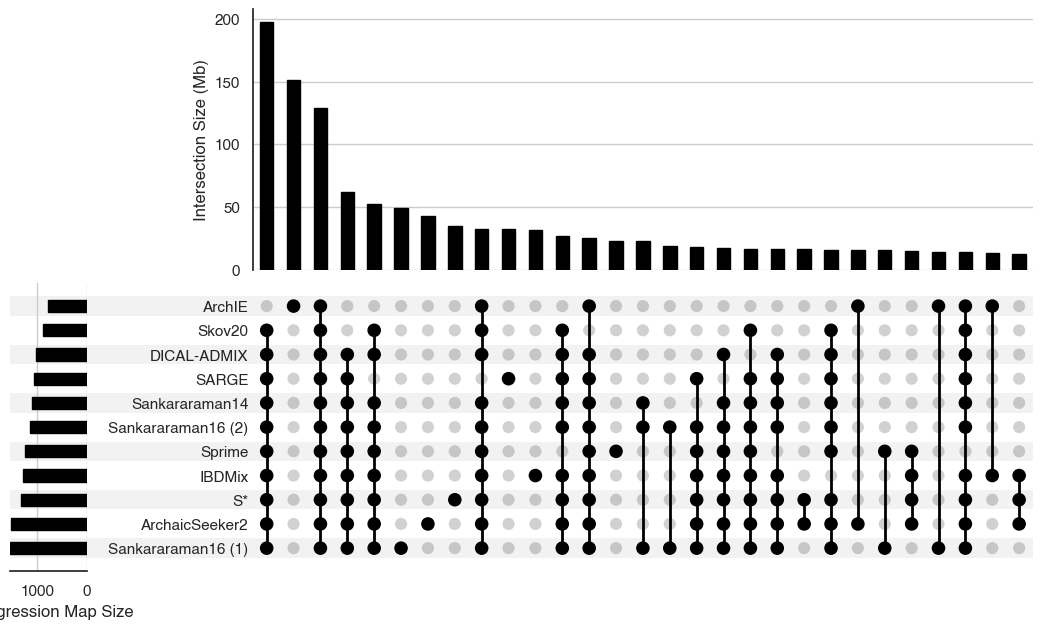

In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_no_argweaver = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_no_argweaver.bed', sep='\t', low_memory=False)
boolean_overlap_no_argweaver = boolean_overlap_no_argweaver.rename(columns=rename_dict)

# change units to mb
boolean_overlap_no_argweaver['mb_length'] = boolean_overlap_no_argweaver['length']/1000000

plt.figure(figsize=(19, 1))

upset_plot = plot(from_indicators(['IBDMix', 'ArchaicSeeker2', 'ArchIE', 'Sprime', 'S*', 
                     'Sankararaman14', 'Sankararaman16 (1)', 'Sankararaman16 (2)', 'Skov20', 
                     'SARGE', 'DICAL-ADMIX'], data=boolean_overlap_no_argweaver), sort_by='cardinality', sum_over="mb_length", subset_size="sum",
                    min_subset_size=12, totals_plot_elements=3, intersection_plot_elements=10, element_size = 25)
                    # min_subset_size: at least 12 Mb in the intersection size
                    # total_plot_elements: make the set sizes bigger
                    # intersection_plot_elements: make intersection plot bigger
                    # element_size: change element size

# set axes titles
upset_plot["intersections"].set_ylabel("Intersection Size (Mb)")
upset_plot["totals"].set_xlabel("Introgression Map Size")

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/upsetplot_bp_longerdim.svg')  

In [ ]:
# get number of Mb where all methods support

# select columns and count True values for all methods
columns_to_count = ['IBDMix', 'ArchaicSeeker2', 'Sprime', 'ArchIE',
                    'S*', 'Sankararaman14', 'Sankararaman16 (1)', 
                    'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE']
boolean_overlap_no_argweaver['methods_support'] = boolean_overlap_no_argweaver[columns_to_count].sum(axis=1)
boolean_overlap_all_methods = boolean_overlap_no_argweaver[boolean_overlap_no_argweaver['methods_support'] == 11]

# get Mb supported by all methods
boolean_overlap_all_methods.mb_length.sum()

129.073403

In [ ]:
# get number of Mb where all methods except archie support
boolean_overlap_no_argweaver_archie = boolean_overlap_no_argweaver[boolean_overlap_no_argweaver['ArchIE'] == False ]
boolean_overlap_no_argweaver_archie

# select columns and count True values, for all methods except archie
columns_to_count = ['IBDMix', 'ArchaicSeeker2', 'Sprime',
                    'S*', 'Sankararaman14', 'Sankararaman16 (1)', 
                    'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE']
boolean_overlap_no_argweaver_archie['methods_support'] = boolean_overlap_no_argweaver_archie[columns_to_count].sum(axis=1)
boolean_overlap_no_argweaver_archie = boolean_overlap_no_argweaver_archie[boolean_overlap_no_argweaver_archie['methods_support'] == 10]

# get Mb supported by all methods except ArchIE
print(boolean_overlap_no_argweaver_archie.mb_length.sum())

197.65052799999998


### Upset Plot -- top 793.9 Mb

<Figure size 2500x200 with 0 Axes>

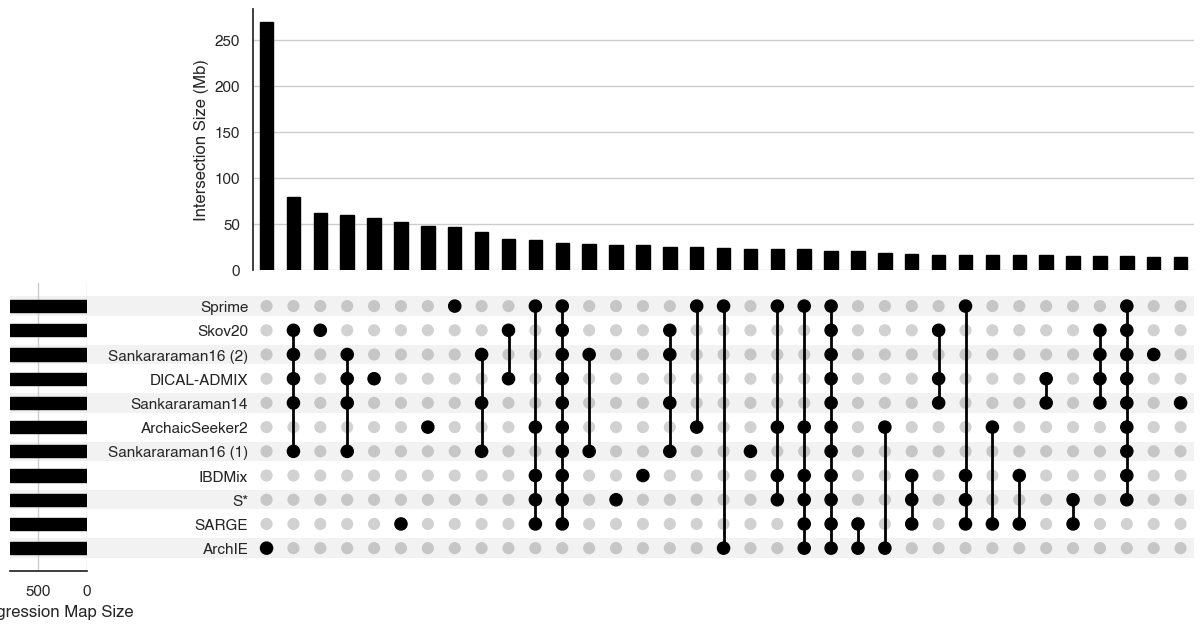

In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_size_matched = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores.bed', sep='\t', low_memory=False)
# exclude columns for boolean transformation
exclude_columns = ['chrom', 'start', 'end', 'length']
# replace 0 as NA
boolean_overlap_size_matched.replace(0, np.nan, inplace=True)
# convert values to boolean values (true or false)
boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)] = boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)].apply(lambda x: pd.notna(x))
# calculate length
boolean_overlap_size_matched['length'] = boolean_overlap_size_matched['end'] - boolean_overlap_size_matched['start']
# rename algorithms
boolean_overlap_size_matched = boolean_overlap_size_matched.rename(columns=rename_dict)
# convert units to mb
boolean_overlap_size_matched['mb_length'] = boolean_overlap_size_matched['length']/1000000

plt.figure(figsize=(25, 2))

upset_plot = plot(from_indicators(['IBDMix', 'ArchaicSeeker2', 'ArchIE', 'Sprime', 'S*', 
                     'Sankararaman14', 'Sankararaman16 (1)', 'Sankararaman16 (2)', 'Skov20', 
                     'SARGE', 'DICAL-ADMIX'], data=boolean_overlap_size_matched), sort_by='cardinality', sum_over="mb_length", subset_size="sum",
                    min_subset_size=13, totals_plot_elements=3, intersection_plot_elements=10, element_size = 25)
                    # min_subset_size: at least 13 Mb in the intersection size
                    # total_plot_elements: make the set sizes bigger
                    # intersection_plot_elements: make intersection plot bigger
                    # element_size: change element size

upset_plot["intersections"].set_ylabel("Intersection Size (Mb)")
upset_plot["totals"].set_xlabel("Introgression Map Size")


pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/upsetplot_bp_sizematched.svg')  

### Num methods supporting each BP -- whole map

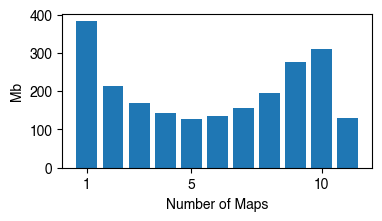

In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_no_argweaver = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_no_argweaver.bed', sep='\t', low_memory=False)
boolean_overlap_no_argweaver = boolean_overlap_no_argweaver.rename(columns=rename_dict)

# calculate True values in each column
true_counts = boolean_overlap_no_argweaver.select_dtypes(include='bool').sum(axis=1)

# group by number of True values, sum the lengths
sum_lengths = boolean_overlap_no_argweaver.groupby(true_counts)['length'].sum()/1000000

plt.figure(figsize=(4,2))
plt.bar(sum_lengths.index, sum_lengths.values)
plt.xlabel('Number of Maps')
plt.ylabel('Mb')
plt.xticks([1,5,10])
plt.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/base_pairs_supported_by_num_algorithms_no_argweaver.svg', dpi=200, bbox_inches='tight')  
plt.show()

### Num methods supporting each BP -- top 793.9 Mb

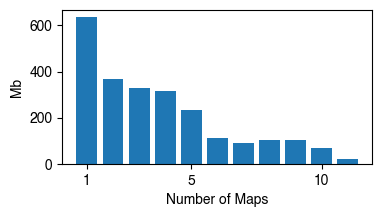

In [ ]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_size_matched = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores.bed', sep='\t', low_memory=False)
# exclude columns for boolean
exclude_columns = ['chrom', 'start', 'end', 'length']
# replace 0 as NA
boolean_overlap_size_matched.replace(0, np.nan, inplace=True)
# convert values to boolean values (true or false)
boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)] = boolean_overlap_size_matched[boolean_overlap_size_matched.columns.difference(exclude_columns)].apply(lambda x: pd.notna(x))
# calculate length
boolean_overlap_size_matched['length'] = boolean_overlap_size_matched['end'] - boolean_overlap_size_matched['start']
# rename algorithms
boolean_overlap_size_matched = boolean_overlap_size_matched.rename(columns=rename_dict)

# count number of True values in each column
true_counts = boolean_overlap_size_matched.select_dtypes(include='bool').sum(axis=1)

# group by number of True values and sum lengths
sum_lengths = boolean_overlap_size_matched.groupby(true_counts)['length'].sum()/1000000

plt.figure(figsize=(4,2))
plt.bar(sum_lengths.index, sum_lengths.values)
plt.xlabel('Number of Maps')
plt.ylabel('Mb')
plt.xticks([1,5,10])
plt.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/base_pairs_support_sizematched.svg', bbox_inches='tight')  
plt.show()

## Plot of distance to next introgressed sequence lengths for individual-level data

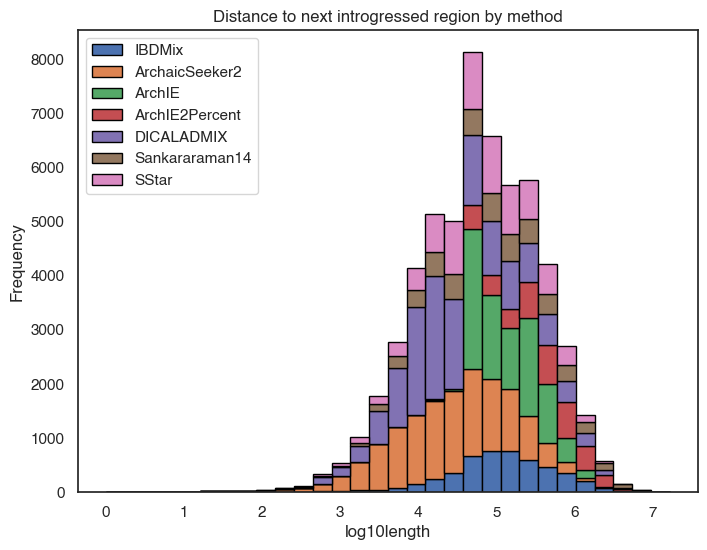

In [ ]:
# we are especially interested in archie
archie_individual_vs_other_methods=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/archie_individual_vs_other_methods.bg', sep='\t', low_memory=False)
archie_individual_vs_other_methods['length'] = archie_individual_vs_other_methods['End'] - archie_individual_vs_other_methods['Start']

dfs = {}

# temp dir to save bg from each method
TEMPDIR=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison'
for method in archie_individual_vs_other_methods['Algorithm'].unique():
    # specify method dir
    # only keep chrom, start, stop for that method
    df = archie_individual_vs_other_methods[archie_individual_vs_other_methods['Algorithm'] == method][['Chromosome', 'Start', 'End']]
    # save to file
    df.to_csv(f'{TEMPDIR}/temp.bg', sep='\t', index=False, header=False)
    # add chr prefix
    !sed -e 's/^/chr/' {TEMPDIR}/temp.bg > {TEMPDIR}/temp_chr_prefix.bg
    # sort
    !sort -k1,1 -k2,2n {TEMPDIR}/temp_chr_prefix.bg > {TEMPDIR}/sorted_temp_chr_prefix.bg
    # run bedtools complement
    # bedtools complement to get the non-introgressed regions for each method
    os.system(f'{BEDTOOLSDIR}/bedtools complement -L -i {TEMPDIR}/sorted_temp_chr_prefix.bg -g {HOMEDIR}/introgression_methods/data/sorted_hg19.fa.fai > {TEMPDIR}/complement.bg')
    # subtract gaps
    os.system(f'{BEDTOOLSDIR}/bedtools subtract -a {TEMPDIR}/complement.bg -b {HOMEDIR}/introgression_methods/data/hg19_gaps.txt > {TEMPDIR}/complement_gaps_removed.bg')
    # read in file
    df = pd.read_csv(f'{TEMPDIR}/complement_gaps_removed.bg', sep='\t', names=['chrom', 'start', 'end'])
    # add length data
    df['length'] = df['end'] - df['start']
    df['log10length'] = np.log10(df['end'] - df['start'])
    # add to dict
    dfs[method]=df
    # remove temp files
    os.system(f'rm {TEMPDIR}/complement_gaps_removed.bg {TEMPDIR}/complement.bg \
                {TEMPDIR}/sorted_temp_chr_prefix.bg {TEMPDIR}/temp_chr_prefix.bg \
                {TEMPDIR}/temp.bg')

# histogram
plt.figure(figsize=(8, 6))
plt.hist([df['log10length'] for df in dfs.values()], 
         bins=30, stacked=True, 
         label=dfs.keys(), edgecolor='black')

plt.xlabel('log10length')
plt.ylabel('Frequency')
plt.title('Distance to next introgressed region by method')
plt.legend()
plt.show()


## Jaccards and Clustering (whole introgression map + thresholded to match the ArchIE's genome-wide amount)

### Autosomes first

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1640: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


save


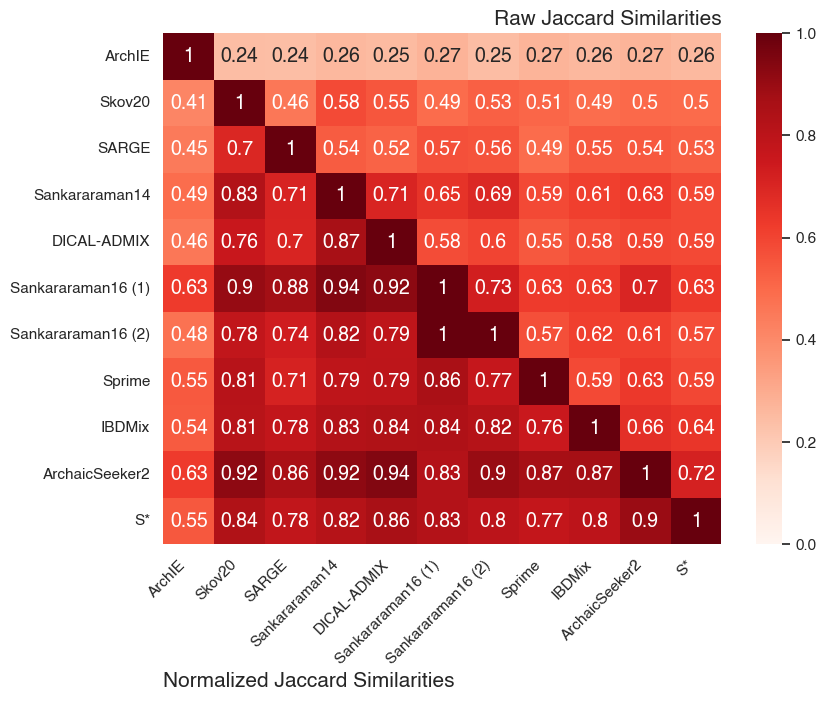

In [49]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_no_argweaver = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_no_argweaver.bed', sep='\t', low_memory=False)
boolean_overlap_no_argweaver = boolean_overlap_no_argweaver.rename(columns=rename_dict)

# generate plot
heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_no_argweaver[boolean_overlap_no_argweaver['chrom']!='X'],
                   categories_list=['IBDMix', 'ArchaicSeeker2',
                                   'ArchIE', 'Sprime', 'S*', 'Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE'],
                   value_column='length', leaf_order=True, 
                   save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/combined_pairwise_jaccard_heatmap_base_pairs.svg')

/scratch/ychen39/ipykernel_3990464/4142242030.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


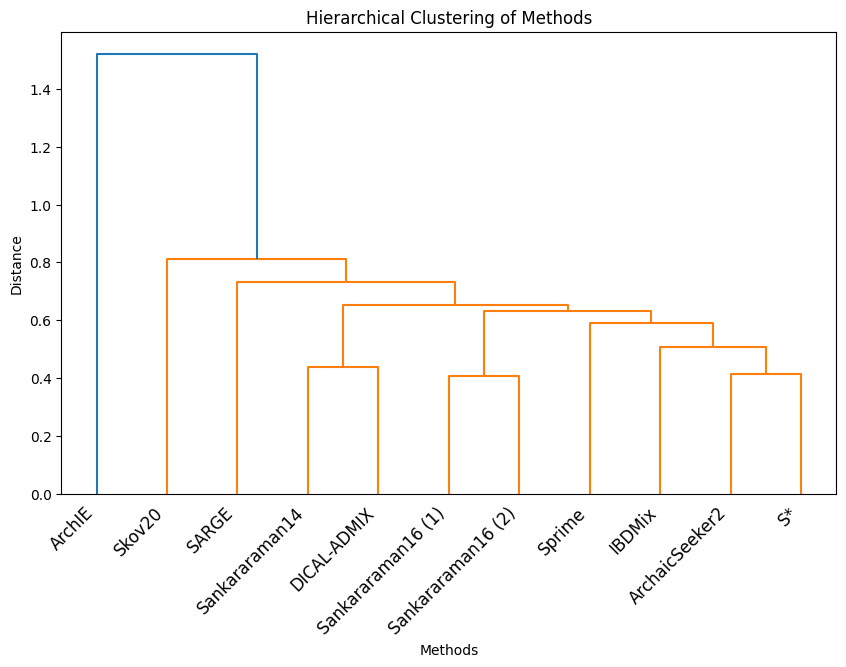

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_no_argweaver_autosomes.svg',bbox_inches='tight')
plt.show()

### X Chromosome only

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1633: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


save


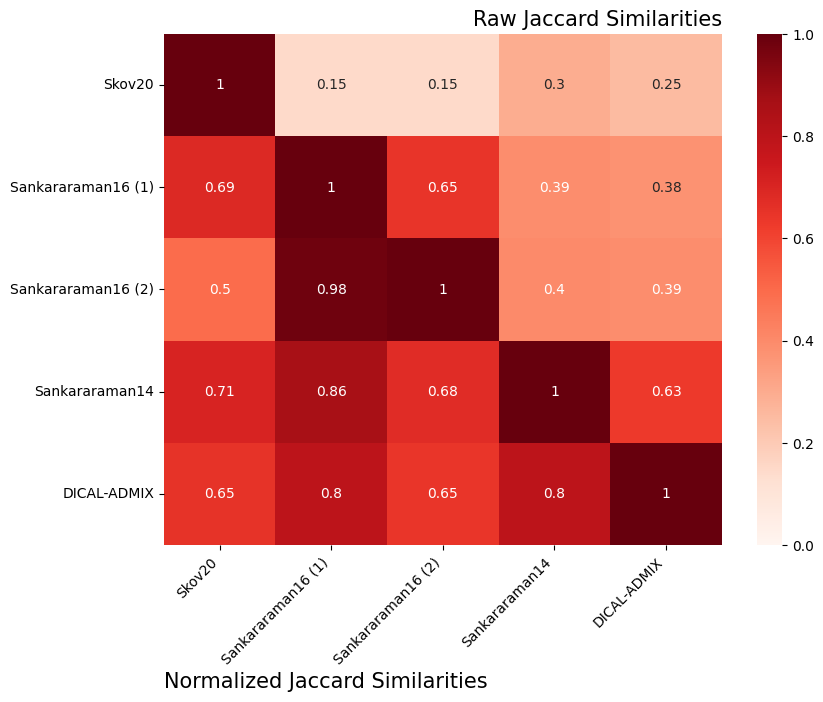

In [7]:
# read in df (generated in 0_wynton_cleaning.ipynb)
boolean_overlap_no_argweaver = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_no_argweaver.bed', sep='\t', low_memory=False)
boolean_overlap_no_argweaver = boolean_overlap_no_argweaver.rename(columns=rename_dict)

# generate plot
heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_no_argweaver[boolean_overlap_no_argweaver['chrom']=='X'],
                   categories_list=['Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX'],
                   value_column='length', leaf_order=True, 
                   save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/combined_pairwise_jaccard_heatmap_base_pairs_X.svg')

/scratch/ychen39/ipykernel_3038428/1636593265.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


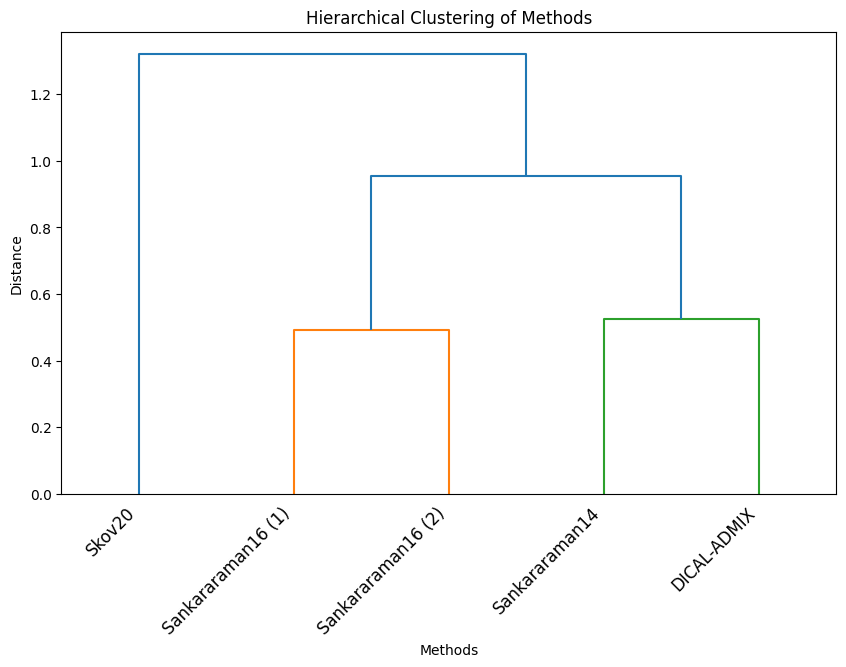

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_no_argweaver_autosomes.svg',bbox_inches='tight')
plt.show()

### Variants only

### Autosomes only

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1644: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


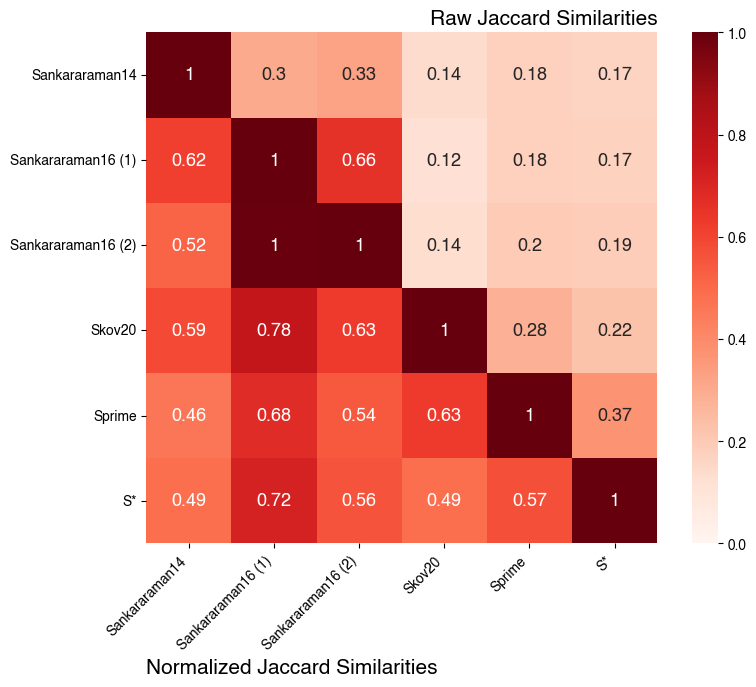

In [5]:
boolean_overlap_variants = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_variants.bed', sep='\t', low_memory=False)
boolean_overlap_variants = boolean_overlap_variants.rename(columns=rename_dict)

heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_variants[boolean_overlap_variants['chrom']!='X'],
                   categories_list=['Sprime', 'S*', 'Sankararaman14', 'Sankararaman16 (1)', 'Sankararaman16 (2)', 
                      'Skov20'],
                   value_column='length', leaf_order=True)

/scratch/ychen39/ipykernel_3990464/3421202358.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


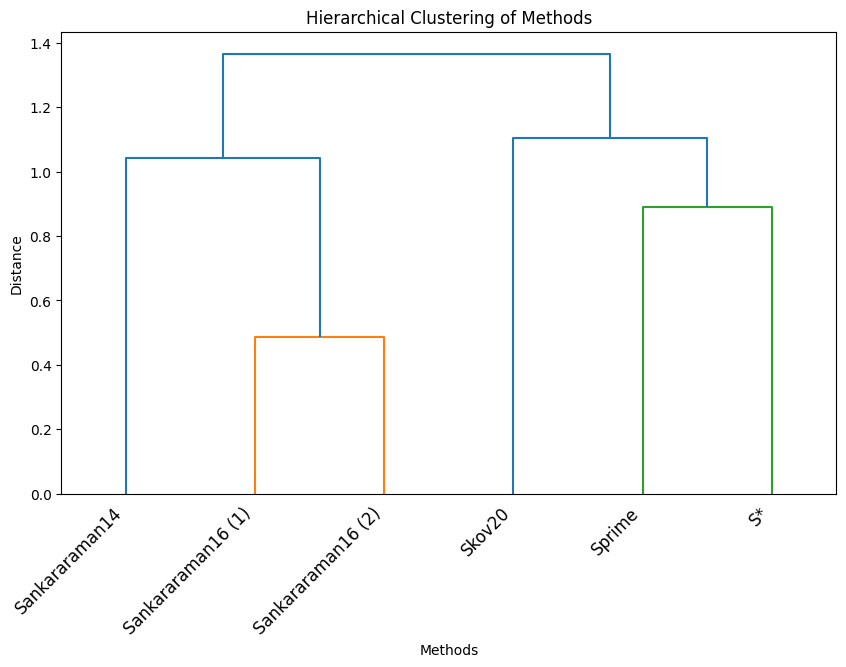

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_variants_autosomes.svg',bbox_inches='tight')
plt.show()

### X only

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1640: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


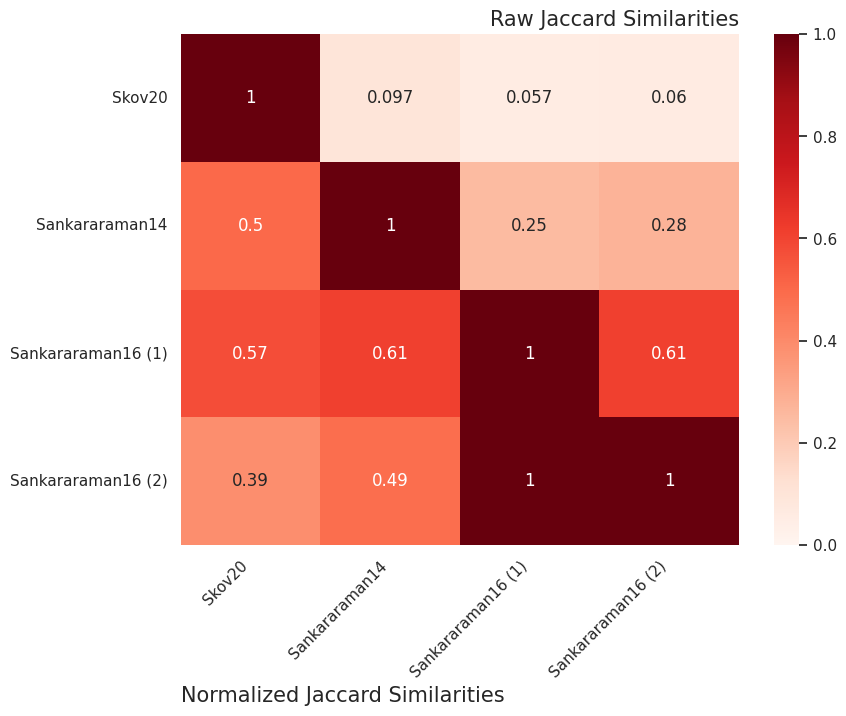

In [9]:
boolean_overlap_variants = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_variants.bed', sep='\t', low_memory=False)
boolean_overlap_variants = boolean_overlap_variants.rename(columns=rename_dict)

heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_variants[boolean_overlap_variants['chrom']=='X'],
                   categories_list=['Sankararaman14', 'Sankararaman16 (1)', 'Sankararaman16 (2)', 'Skov20'],
                   value_column='length', leaf_order=True)

/tmp/ipykernel_4147839/2899688473.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


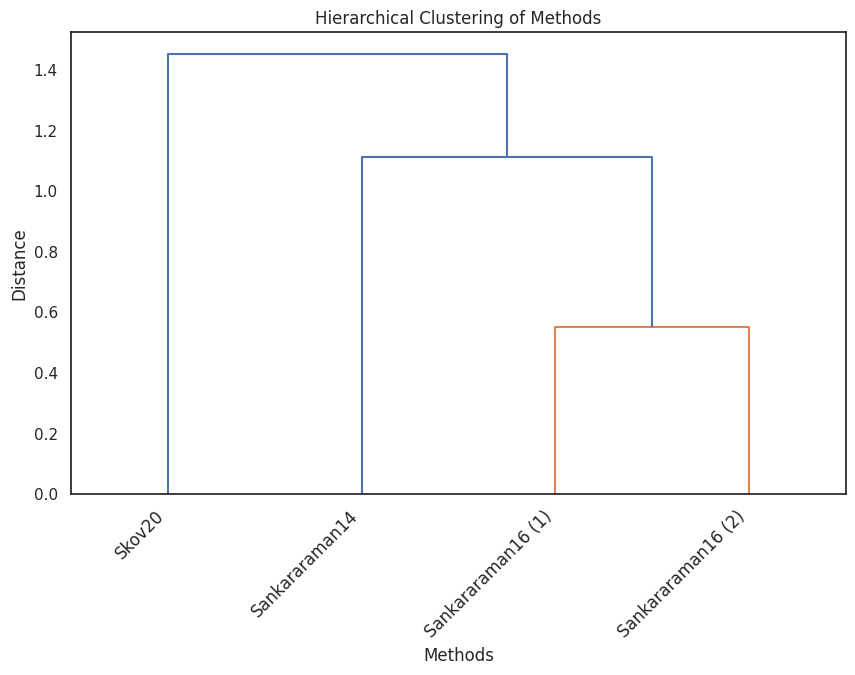

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_variants_X.svg',bbox_inches='tight')
plt.show()

#### Thresholded -- Subset to highest scoring regions the size of ArchIE

##### Autosomes Only

In [ ]:
# calculate threshold
# remove header from 
methods_dirs = ['chen_2020', 'yuan_2021', 'durvasula_2019', 'steinruecken_2018', 'skov_2020', 'schaefer_2021', 'browning_2018', 'vernot_2016', 'sankararaman_2014', 'sankararaman_2016_1', 'sankararaman_2016_2']
# bedtools complement to get the non-introgressed regions for each method
for method in methods_dirs:
    method_dir = f'/introgression_methods/cleaned/introgression_tools/{method}'
    with open(f'{HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg', 'r') as f:
        first_line = f.readline()
        if 'chrom' in first_line.lower():
            !sed -e '1d' -i {HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg

proportions = {}

for method in methods_dirs:
    method_dir = f'/introgression_methods/cleaned/introgression_tools/{method}'
    df = pd.read_csv(f'{HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg', sep='\t', low_memory=False, names=['chrom', 'Start', 'End', 'Score'])
    # compute length
    df['length'] = df['End'] - df['Start']
    # compute the minumum amount of introgression across people
    min_sum = df['length'].sum().min()
    # add the minimum amount to the dict
    proportions[method] = min_sum
    
# get the smallest value to use as length_threshold
length_threshold = min(proportions.values())
print(proportions, length_threshold)

{'chen_2020': 1291413343, 'yuan_2021': 1534838051, 'durvasula_2019': 793900000, 'steinruecken_2018': 1023339000, 'skov_2020': 889069710, 'schaefer_2021': 1068860156, 'browning_2018': 1243444992, 'vernot_2016': 1339505007, 'sankararaman_2014': 1117531142, 'sankararaman_2016_1': 1558018928, 'sankararaman_2016_2': 1141804104} 793900000


In [14]:
boolean_overlap_shared_length_highest_scores = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/durvasula_2019/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/browning_2018/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_1/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_2/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/skov_2020/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/union_merged_highest_score.bg',
                                           input_files_names_str='ibdmix archaicseeker archie sprime vernot_2016 sankararaman_2014 sankararaman_2016_1 sankararaman_2016_2 skov_2020 steinruecken_2018 sarge',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores.bed',
                                           boolean=True, autosomes=True, length_threshold=793900000)
# only information on fragment sizes, region level - no argweaver
boolean_overlap_shared_length_highest_scores = boolean_overlap_shared_length_highest_scores.rename(columns=rename_dict)

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1662: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


save


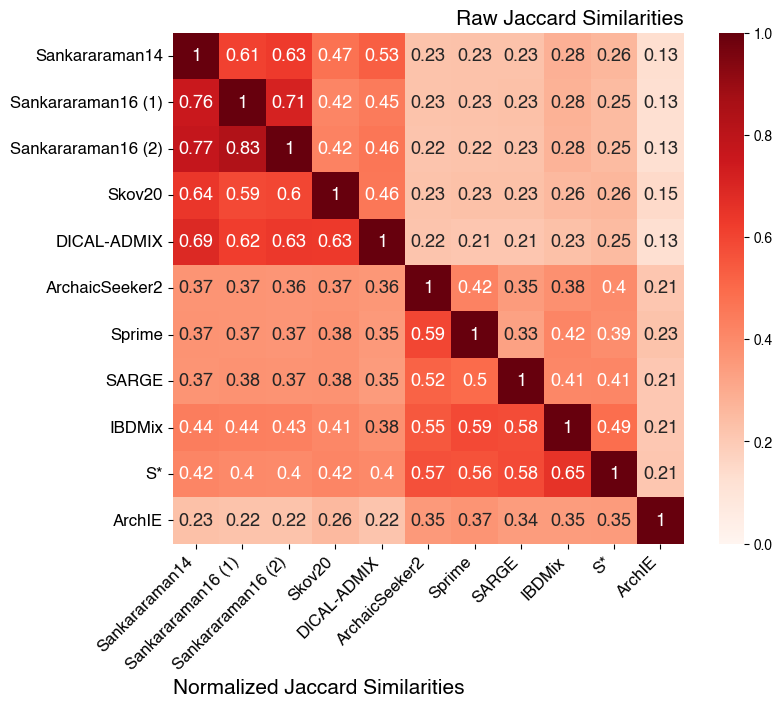

In [47]:
heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_shared_length_highest_scores[boolean_overlap_shared_length_highest_scores['chrom']!='X'],
                   categories_list=['IBDMix', 'ArchaicSeeker2',
                                   'ArchIE', 'Sprime', 'S*', 'Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE'],
                   value_column='length', leaf_order=[5, 6, 7, 8, 9, 1, 3, 10, 0, 4, 2],
                    save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/jaccard_archie_size_subset.svg')

/tmp/ipykernel_2551816/4135978819.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


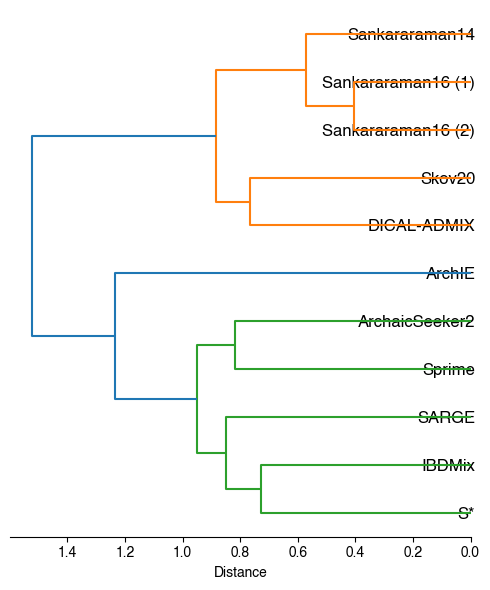

In [ ]:
distance_matrix = 1 - heatmap_data

# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

fig, ax = plt.subplots(figsize=(5, 6))

# plot with specified labels
dendrogram(
    Z,
    labels=heatmap_data.columns,
    orientation='right',
    leaf_rotation=90
)

plt.xlabel('Distance')

# move y axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("left")
# remove y ticks
ax.tick_params(axis='y', length=0)
# rotate y labels
plt.yticks(rotation=0, ha='right')

# mirror the plot
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
# remove border
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
# keep x axis line
ax.spines['bottom'].set_visible(True)

plt.tight_layout()

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_archie_size_subset.svg',bbox_inches='tight')

plt.show()

##### X Only

In [16]:
# calculate threshold
# remove header from 
methods_dirs = ['steinruecken_2018', 'skov_2020', 'sankararaman_2014', 'sankararaman_2016_1', 'sankararaman_2016_2']
for method in methods_dirs:
    method_dir = f'/introgression_methods/cleaned/introgression_tools/{method}'
    with open(f'{HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg', 'r') as f:
        first_line = f.readline()
        if 'chrom' in first_line.lower():
            !sed -e '1d' -i {HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg

proportions = {}
for method in methods_dirs:
    method_dir = f'/introgression_methods/cleaned/introgression_tools/{method}'
    df = pd.read_csv(f'{HOMEDIR}/{method_dir}/bedgraphs/union_merged_highest_score.bg', sep='\t', low_memory=False, names=['chrom', 'Start', 'End', 'Score'])
    # subset to autosomes
    df = df[df['chrom']=='X']
    # compute length
    df['length'] = df['End'] - df['Start']
    # compute the minumum amount of introgression across people
    min_sum = df['length'].sum().min()
    # add the minimum amount to the dict
    proportions[method] = min_sum
# get the smallest value to use as length_threshold
length_threshold = min(proportions.values())
print(proportions, length_threshold)

{'steinruecken_2018': 17681500, 'skov_2020': 7814066, 'sankararaman_2014': 16521984, 'sankararaman_2016_1': 33986160, 'sankararaman_2016_2': 22769048} 7814066


In [17]:
boolean_overlap_shared_length_highest_scores = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/durvasula_2019/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/browning_2018/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_1/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_2/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/skov_2020/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/bedgraphs/union_merged_highest_score.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/union_merged_highest_score.bg',
                                           input_files_names_str='ibdmix archaicseeker archie sprime vernot_2016 sankararaman_2014 sankararaman_2016_1 sankararaman_2016_2 skov_2020 steinruecken_2018 sarge',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores.bed',
                                           boolean=True, x_only=True, length_threshold=7814066)
# only information on fragment sizes, region level - no argweaver
boolean_overlap_shared_length_highest_scores = boolean_overlap_shared_length_highest_scores.rename(columns=rename_dict)

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1640: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


save


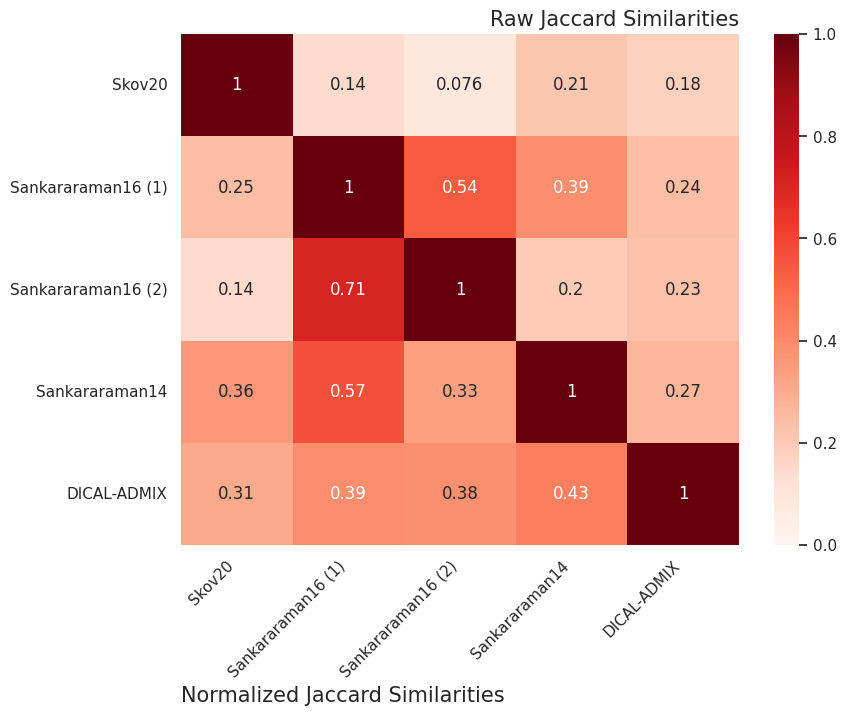

In [18]:
heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_shared_length_highest_scores[boolean_overlap_shared_length_highest_scores['chrom']=='X'],
                   categories_list=['Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX'],
                   value_column='length', leaf_order=True,
                    save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/jaccard_archie_size_subset_X_only.svg')

/tmp/ipykernel_4147839/505130891.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


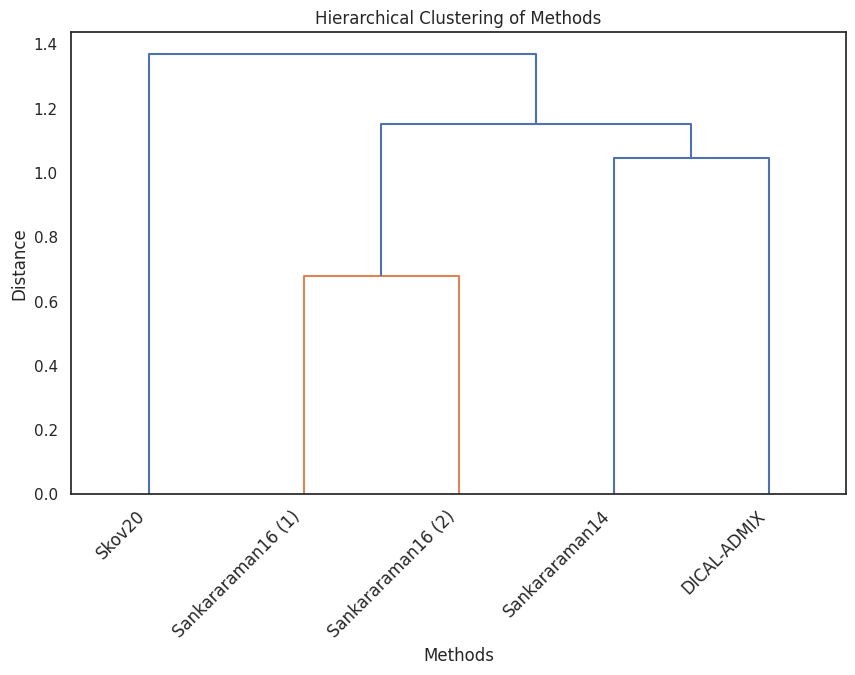

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
# pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_archie_size_subset.svg',bbox_inches='tight')
plt.show()

#### Thresholded EUR only -- Subset to highest scoring regions the size of ArchIE

Only look at EUR regions for each method

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1641: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  distance_matrix = 1 - heatmap_data


save


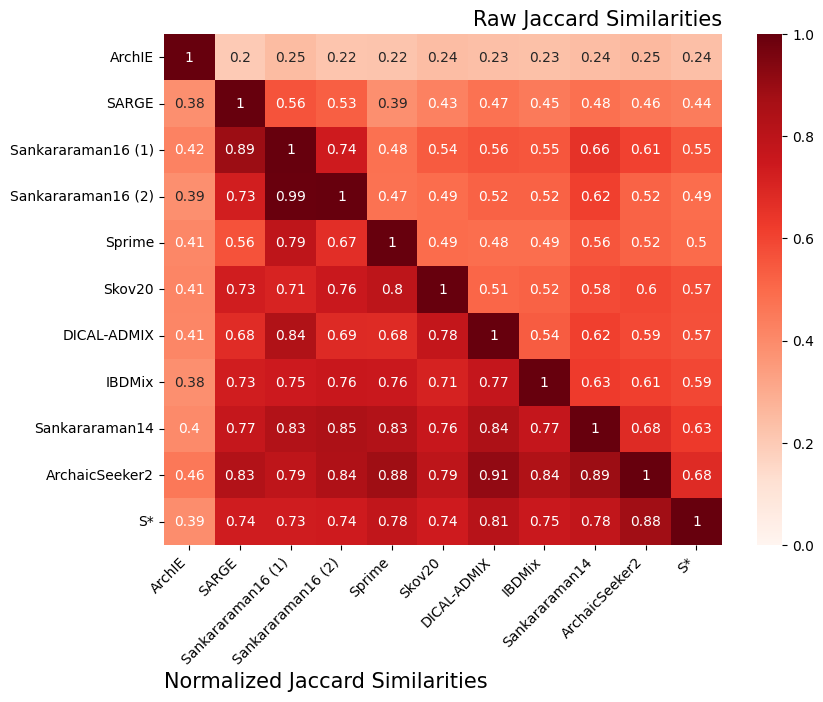

In [ ]:
# also a version with EUR regions only
boolean_overlap_shared_length_highest_scores_EUR = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/durvasula_2019/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/browning_2018/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_1/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_2/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/skov_2020/bedgraphs/merged_Icelandic.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/bedgraphs/merged_CEU.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/merged_WestEurasia.bg',
                                           input_files_names_str='ibdmix archaicseeker archie sprime vernot_2016 sankararaman_2014 sankararaman_2016_1 sankararaman_2016_2 skov_2020 steinruecken_2018 sarge',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/test.bed',
                                           boolean=True, autosomes=True)

boolean_overlap_shared_length_highest_scores_EUR = boolean_overlap_shared_length_highest_scores_EUR.rename(columns=rename_dict)

heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_shared_length_highest_scores_EUR,
                   categories_list=['IBDMix', 'ArchaicSeeker2',
                                   'ArchIE', 'Sprime', 'S*', 'Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE'],
                   value_column='length', leaf_order=True,
                    save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/test.svg')

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:1641: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  distance_matrix = 1 - heatmap_data


save


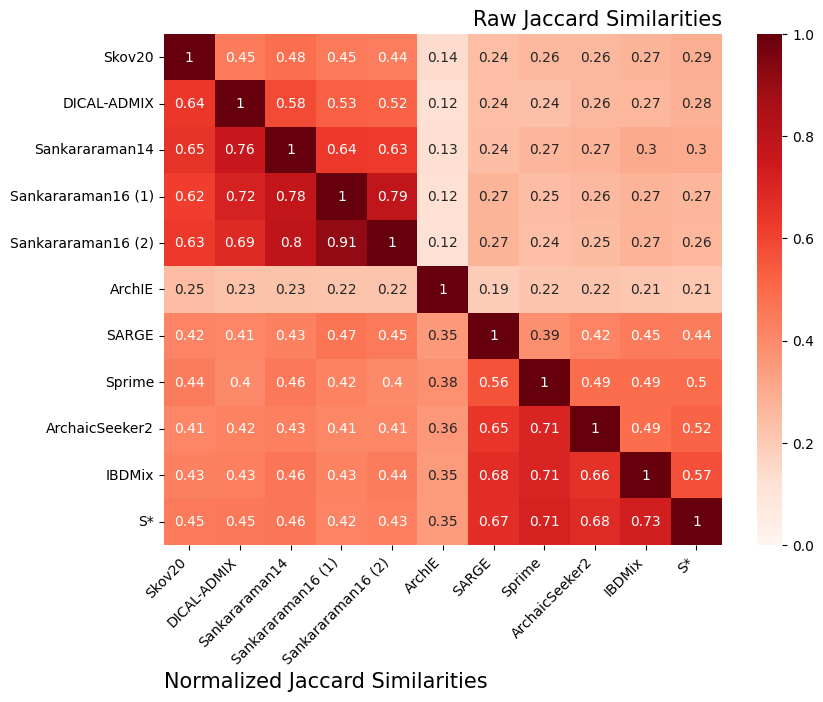

In [ ]:
# also a version with EUR regions only
boolean_overlap_shared_length_highest_scores_EUR = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/durvasula_2019/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/browning_2018/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_1/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_2/bedgraphs/merged_EUR.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/skov_2020/bedgraphs/merged_Icelandic.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/bedgraphs/merged_CEU.bg \
    {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/merged_WestEurasia.bg',
                                           input_files_names_str='ibdmix archaicseeker archie sprime vernot_2016 sankararaman_2014 sankararaman_2016_1 sankararaman_2016_2 skov_2020 steinruecken_2018 sarge',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/boolean_overlap_shared_length_highest_scores_EUR.bed',
                                           boolean=True, autosomes=True, length_threshold=719560342)

boolean_overlap_shared_length_highest_scores_EUR = boolean_overlap_shared_length_highest_scores_EUR.rename(columns=rename_dict)

heatmap_data=tools.plot_jaccard(boolean_df=boolean_overlap_shared_length_highest_scores_EUR,
                   categories_list=['IBDMix', 'ArchaicSeeker2',
                                   'ArchIE', 'Sprime', 'S*', 'Sankararaman14', 'Sankararaman16 (1)',
                                   'Sankararaman16 (2)', 'Skov20', 'DICAL-ADMIX', 'SARGE'],
                   value_column='length', leaf_order=True,
                    save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/jaccard_archie_size_subset_EUR.svg')

/scratch/ychen39/ipykernel_3327492/2443334115.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


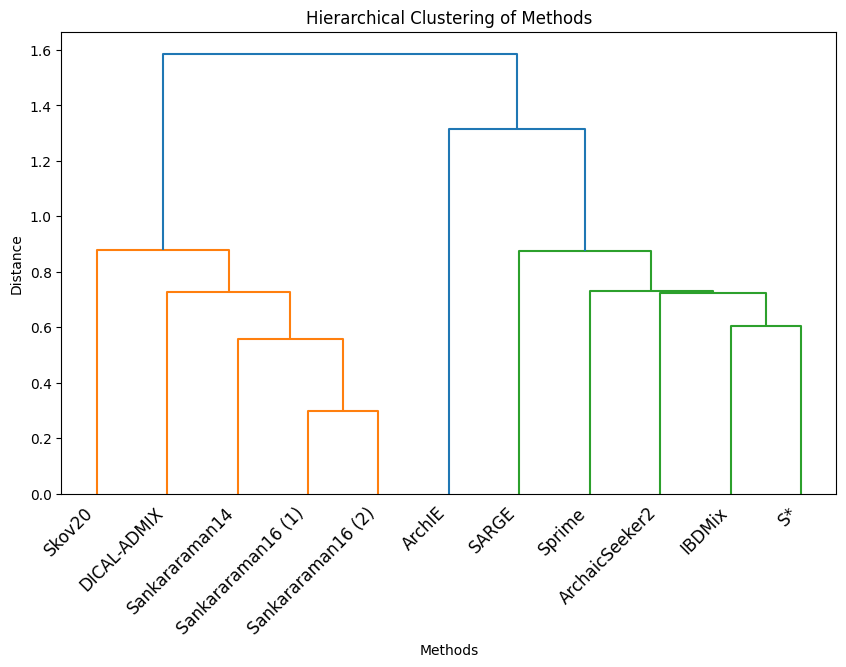

In [ ]:
distance_matrix = 1 - heatmap_data
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/clustering_jaccard_archie_size_subset_EUR.svg',bbox_inches='tight')
plt.show()

## Individual-Level Jaccard

### 84 CEU individuals (ArchIE)

In [ ]:
# Read in individual-level files

ibdmix_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/individual_nean_chen2020_frag.bed', sep='\t', low_memory=False)
archaicseeker2_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/individual_nean_yuan2021_frag.bed', sep='\t', low_memory=False)
archaicseeker2_individual['ID'] = archaicseeker2_individual['ID'].str.split('_').str[0]
archie_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/durvasula_2019/individual_nean_durvasula2019_frag.bed', sep='\t', low_memory=False)
dicaladmix_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/individual_introgressed_steinruecken2018_frag.bed', sep='\t', low_memory=False)
dicaladmix_individual['Chromosome'] = dicaladmix_individual['Chromosome'].str.replace('chr', '')
sankararaman_2014_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/1kgids_individual_neanderthal_introgressed_fragments_pops.bed', sep='\t', low_memory=False)
vernot_2016_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/neanderthal_introgressed_haplotypes_individual.bed', sep='\t', low_memory=False)

# make into dictionary
dfs_dict = {'IBDMix':ibdmix_individual, 
       'ArchaicSeeker2':archaicseeker2_individual, 
       'ArchIE':archie_individual,
        'DICALADMIX':dicaladmix_individual,
           'Sankararaman14':sankararaman_2014_individual,
           'SStar':vernot_2016_individual}

ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_individual = pd.concat([df.assign(Algorithm=k) for k,df in dfs_dict.items()])

ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_individual

,Chromosome,Start,End,Score,Population,Ancestry,ID,ScoreName,IntrogressionSource,Method,GenomesSource,Algorithm,ScoreName_New,Individual,length
0,1,814106,868418,12.037900,JPT,EAS,NA18948,LOD,Neanderthal,"IBDmix, Chen 2020",1KG Phase 3,IBDMix,NaN,NaN,NaN
1,1,814106,868418,12.037900,JPT,EAS,NA18967,LOD,Neanderthal,"IBDmix, Chen 2020",1KG Phase 3,IBDMix,NaN,NaN,NaN
2,1,814106,869948,10.832600,JPT,EAS,NA18942,LOD,Neanderthal,"IBDmix, Chen 2020",1KG Phase 3,IBDMix,NaN,NaN,NaN
3,1,814106,869948,10.832600,JPT,EAS,NA18953,LOD,Neanderthal,"IBDmix, Chen 2020",1KG Phase 3,IBDMix,NaN,NaN,NaN
4,1,814106,869948,8.931720,JPT,EAS,NA19002,LOD,Neanderthal,"IBDmix, Chen 2020",1KG Phase 3,IBDMix,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934866,9,140948572,141014566,0.949085,NaN,EAS,NA18985,NaN,NaN,NaN,NaN,SStar,NaN,NaN,NaN
934867,9,140948572,141014566,0.949085,NaN,EAS,NA18997,NaN,NaN,NaN,NaN,SStar,NaN,NaN,NaN
934868,9,140948572,141014566,0.949085,NaN,EAS,NA19056,NaN,NaN,NaN,NaN,SStar,NaN,NaN,NaN
934869,9,140948572,141014566,0.949085,NaN,EAS,NA19060,NaN,NaN,NaN,NaN,SStar,NaN,NaN,NaN


#### autosomes only 

In [14]:
heatmap_data=tools.individual_jaccard_comparison(dfs_dict = dfs_dict,
    temp_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/', 
    output_jaccards_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_function_version.tsv',
    # also save the ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_individual file so we can compute lengths distributions across these methods
    # mainly to compare against archie      
    save_shared_individuals_bed=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/archie_shared_individual_vs_other_methods.bg',
    return_heatmap=True,
    autosomes_only=True,
    x_only=False)

['IBDMix', 'ArchaicSeeker2', 'ArchIE', 'DICALADMIX', 'Sankararaman14', 'SStar'] : 84 individuals shared,  ['NA06984', 'NA06986', 'NA06989', 'NA06994', 'NA07000', 'NA07037', 'NA07048', 'NA07051', 'NA07056', 'NA07347', 'NA07357', 'NA10847', 'NA10851', 'NA11829', 'NA11830', 'NA11831', 'NA11843', 'NA11892', 'NA11893', 'NA11894', 'NA11919', 'NA11920', 'NA11930', 'NA11931', 'NA11932', 'NA11933', 'NA11992', 'NA11994', 'NA11995', 'NA12003', 'NA12004', 'NA12006', 'NA12043', 'NA12044', 'NA12045', 'NA12046', 'NA12058', 'NA12144', 'NA12154', 'NA12155', 'NA12249', 'NA12272', 'NA12273', 'NA12275', 'NA12282', 'NA12283', 'NA12286', 'NA12287', 'NA12340', 'NA12341', 'NA12342', 'NA12347', 'NA12348', 'NA12383', 'NA12399', 'NA12400', 'NA12413', 'NA12489', 'NA12546', 'NA12716', 'NA12717', 'NA12718', 'NA12748', 'NA12749', 'NA12750', 'NA12751', 'NA12761', 'NA12763', 'NA12775', 'NA12777', 'NA12778', 'NA12812', 'NA12814', 'NA12815', 'NA12827', 'NA12829', 'NA12830', 'NA12842', 'NA12843', 'NA12872', 'NA12873', 'N

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:2142: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


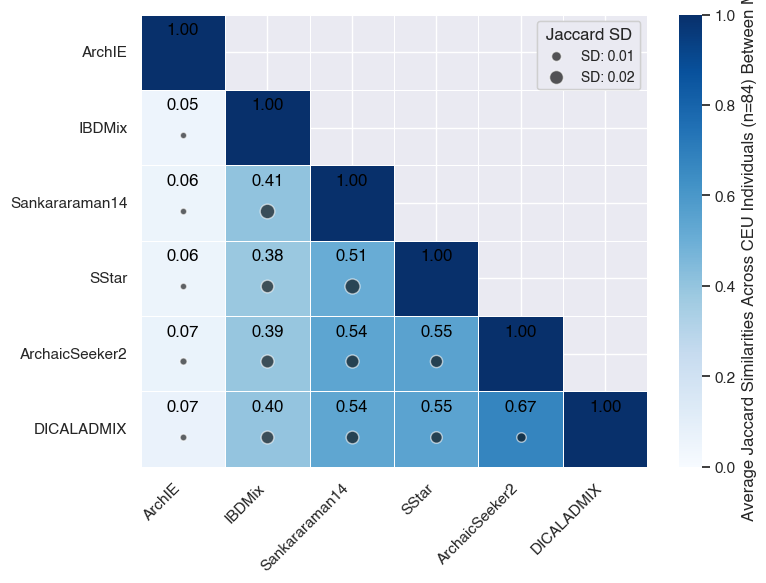

In [17]:
tools.individual_jaccard_comparison_dot_heatmap(
    heatmap_data=heatmap_data,
    tsv=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_function_version.tsv',
    color='Blues',
    save_plot_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_function_version.svg',
    sd_sizes=[0.01, 0.02],
    legend_title = 'Average Jaccard Similarities Across CEU Individuals (n=84) Between Maps'
)

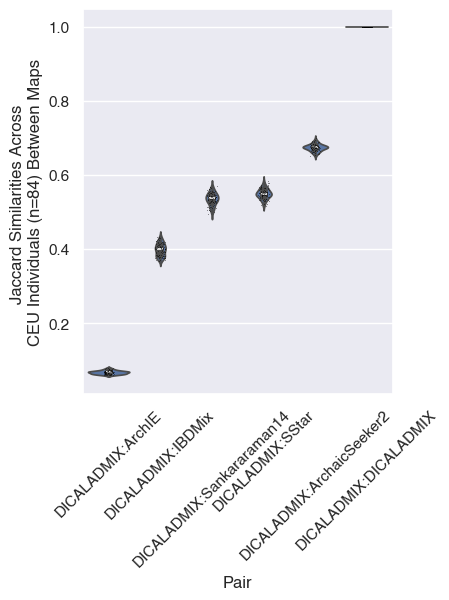

In [28]:
# violin plot of just archie's data
# load precomputed jaccard data
archie_v_others_jaccard=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_function_version.tsv', sep='\t', low_memory=False)
# subset to only DICALADMIX
archie_v_others_jaccard_filt = archie_v_others_jaccard[archie_v_others_jaccard['Pair'].str.contains('DICALADMIX:', na=False)]

# calculate average values for each category
avg_values = archie_v_others_jaccard_filt.groupby('Pair')['Jaccard'].mean().sort_values()

# order categories by average values
ordered_categories = avg_values.index

plt.figure(figsize=(4, 5))
sns.violinplot(data=archie_v_others_jaccard, x='Pair', y='Jaccard', order=ordered_categories)
# Overlay a strip plot with jitter
sns.stripplot(data=archie_v_others_jaccard, x='Pair', y='Jaccard', jitter=True, color='black', size=0.4, order=ordered_categories)

plt.xticks(rotation=45)
plt.ylabel('Jaccard Similarities Across \nCEU Individuals (n=84) Between Maps')

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/archie_v_others_violin.svg', bbox_inches='tight')
plt.show()

/scratch/ychen39/ipykernel_2202139/3504315171.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


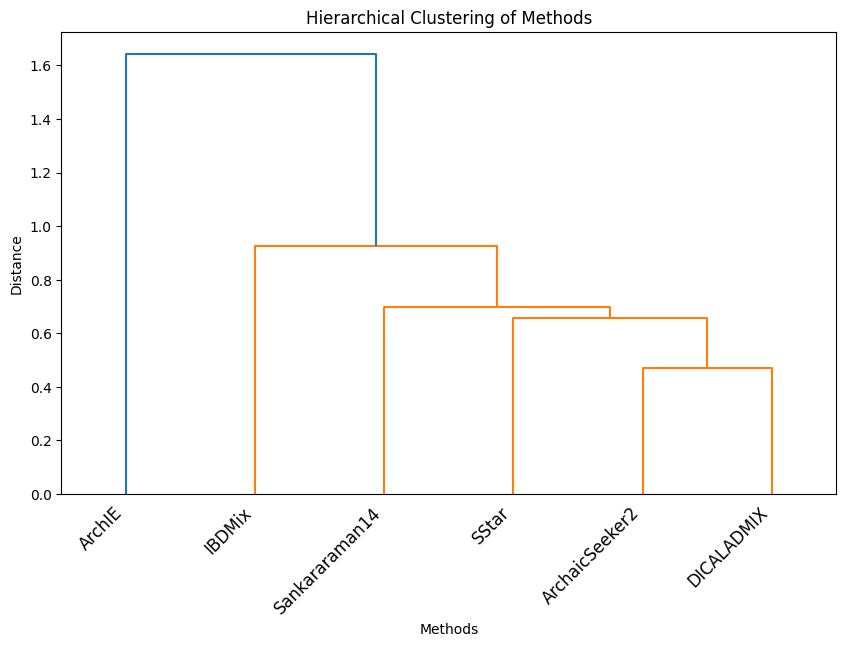

In [ ]:
df= pd.concat(heatmap_data).groupby(level=0).mean()

df_reordered = df.reindex(columns=df.columns, index=df.columns)

distance_matrix = 1 - df_reordered
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df_reordered.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
#pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/clustering.png', dpi=300, bbox_inches='tight')
plt.show()

#### X only (did not put in paper)

In [ ]:
# report number of IDs shared between methods
    # get list of different algorithms in comparison
num_algorithms = len(dfs_dict)
algorithms = list(dfs_dict.keys())

# make combined dataframe
individual_concat = pd.concat([df.assign(Algorithm=k) for k,df in dfs_dict.items()])
# keep autosomes only
individual_concat = individual_concat[individual_concat['Chromosome'] == 'X']
    
# group by ID, count unique values in 'Value'
id_value_counts = individual_concat.groupby('ID')['Algorithm'].nunique()
# filter IDs counted in all individual level dataframes
shared_individuals = id_value_counts[id_value_counts == num_algorithms].index.tolist()    
print(algorithms, ":", len(shared_individuals), 'individuals shared, ', shared_individuals)

['DICALADMIX', 'Sankararaman14'] : 265 individuals shared,  ['HG00403', 'HG00404', 'HG00406', 'HG00407', 'HG00418', 'HG00419', 'HG00421', 'HG00422', 'HG00427', 'HG00428', 'HG00436', 'HG00437', 'HG00442', 'HG00443', 'HG00446', 'HG00448', 'HG00449', 'HG00451', 'HG00452', 'HG00457', 'HG00458', 'HG00463', 'HG00464', 'HG00472', 'HG00473', 'HG00476', 'HG00478', 'HG00479', 'HG00500', 'HG00501', 'HG00512', 'HG00513', 'HG00525', 'HG00530', 'HG00531', 'HG00533', 'HG00534', 'HG00536', 'HG00537', 'HG00542', 'HG00543', 'HG00556', 'HG00557', 'HG00559', 'HG00560', 'HG00565', 'HG00566', 'HG00577', 'HG00578', 'HG00580', 'HG00581', 'HG00583', 'HG00584', 'HG00589', 'HG00590', 'HG00592', 'HG00593', 'HG00596', 'HG00607', 'HG00608', 'HG00610', 'HG00611', 'HG00614', 'HG00619', 'HG00625', 'HG00626', 'HG00628', 'HG00629', 'HG00634', 'HG00635', 'HG00650', 'HG00651', 'HG00653', 'HG00654', 'HG00656', 'HG00657', 'HG00662', 'HG00663', 'HG00671', 'HG00672', 'HG00683', 'HG00684', 'HG00689', 'HG00690', 'HG00692', 'HG0

In [40]:
dfs_dict = {'DICALADMIX':dicaladmix_individual,
           'Sankararaman14':sankararaman_2014_individual}


heatmap_data=tools.individual_jaccard_comparison(dfs_dict = dfs_dict,
    temp_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/', 
    output_jaccards_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_x_only.tsv',   
    return_heatmap=True,
    autosomes_only=False,
    x_only=True)

['DICALADMIX', 'Sankararaman14'] : 265 individuals shared,  ['HG00403', 'HG00404', 'HG00406', 'HG00407', 'HG00418', 'HG00419', 'HG00421', 'HG00422', 'HG00427', 'HG00428', 'HG00436', 'HG00437', 'HG00442', 'HG00443', 'HG00446', 'HG00448', 'HG00449', 'HG00451', 'HG00452', 'HG00457', 'HG00458', 'HG00463', 'HG00464', 'HG00472', 'HG00473', 'HG00476', 'HG00478', 'HG00479', 'HG00500', 'HG00501', 'HG00512', 'HG00513', 'HG00525', 'HG00530', 'HG00531', 'HG00533', 'HG00534', 'HG00536', 'HG00537', 'HG00542', 'HG00543', 'HG00556', 'HG00557', 'HG00559', 'HG00560', 'HG00565', 'HG00566', 'HG00577', 'HG00578', 'HG00580', 'HG00581', 'HG00583', 'HG00584', 'HG00589', 'HG00590', 'HG00592', 'HG00593', 'HG00596', 'HG00607', 'HG00608', 'HG00610', 'HG00611', 'HG00614', 'HG00619', 'HG00625', 'HG00626', 'HG00628', 'HG00629', 'HG00634', 'HG00635', 'HG00650', 'HG00651', 'HG00653', 'HG00654', 'HG00656', 'HG00657', 'HG00662', 'HG00663', 'HG00671', 'HG00672', 'HG00683', 'HG00684', 'HG00689', 'HG00690', 'HG00692', 'HG0

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:2120: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  # Compute distance matrix (from the average Jaccard similarities)


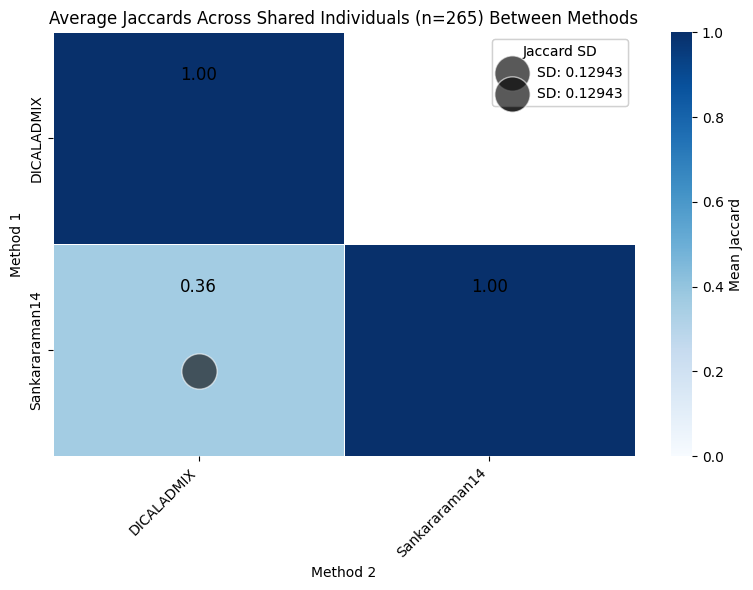

In [ ]:
tools.individual_jaccard_comparison_dot_heatmap(
    heatmap_data=heatmap_data,
    tsv=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_x_only.tsv',
    title='Average Jaccards Across Shared Individuals (n=265) Between Methods',
    color='Blues',
    save_plot_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/ibdmix_archaicseeker2_archie_dicaladmix_sstar_sankararaman14_jaccard_x_only.svg'
)

### 271 CEU and CHBS individuals

In [19]:
ibdmix_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/individual_nean_chen2020_frag.bed', sep='\t', low_memory=False)
archaicseeker2_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/individual_nean_yuan2021_frag.bed', sep='\t', low_memory=False)
archaicseeker2_individual['ID'] = archaicseeker2_individual['ID'].str.split('_').str[0]
dicaladmix_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/steinruecken_2018/individual_introgressed_steinruecken2018_frag.bed', sep='\t', low_memory=False)
dicaladmix_individual['Chromosome'] = dicaladmix_individual['Chromosome'].str.replace('chr', '')
sankararaman_2014_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2014/1kgids_individual_neanderthal_introgressed_fragments_pops.bed', sep='\t', low_memory=False)
vernot_2016_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/vernot_2016/neanderthal_introgressed_haplotypes_individual.bed', sep='\t', low_memory=False)

dfs_dict = {'IBDMix':ibdmix_individual, 
       'ArchaicSeeker2':archaicseeker2_individual, 
        'DICALADMIX':dicaladmix_individual,
           'Sankararaman14':sankararaman_2014_individual,
           'SStar':vernot_2016_individual}

ibdmix_archaicseeker2_dicaladmix_sstar_sankararaman14_individual = pd.concat([df.assign(Algorithm=k) for k,df in dfs_dict.items()])

heatmap_data=tools.individual_jaccard_comparison(dfs_dict = dfs_dict,
                              autosomes_only=True,
                              temp_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/tmp', 
                              output_jaccards_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_dicaladmix_sstar_sankararaman14_min_subset_individual.tsv',
                              return_heatmap=True)

['IBDMix', 'ArchaicSeeker2', 'DICALADMIX', 'Sankararaman14', 'SStar'] : 271 individuals shared,  ['HG00403', 'HG00404', 'HG00406', 'HG00407', 'HG00419', 'HG00421', 'HG00422', 'HG00428', 'HG00436', 'HG00437', 'HG00442', 'HG00443', 'HG00445', 'HG00446', 'HG00448', 'HG00449', 'HG00451', 'HG00452', 'HG00457', 'HG00458', 'HG00463', 'HG00464', 'HG00472', 'HG00473', 'HG00475', 'HG00476', 'HG00478', 'HG00479', 'HG00500', 'HG00513', 'HG00524', 'HG00525', 'HG00530', 'HG00531', 'HG00533', 'HG00534', 'HG00536', 'HG00537', 'HG00542', 'HG00543', 'HG00556', 'HG00557', 'HG00559', 'HG00560', 'HG00565', 'HG00566', 'HG00580', 'HG00581', 'HG00583', 'HG00584', 'HG00589', 'HG00590', 'HG00592', 'HG00593', 'HG00595', 'HG00596', 'HG00607', 'HG00608', 'HG00610', 'HG00611', 'HG00613', 'HG00614', 'HG00619', 'HG00620', 'HG00625', 'HG00626', 'HG00628', 'HG00629', 'HG00634', 'HG00650', 'HG00651', 'HG00653', 'HG00654', 'HG00656', 'HG00657', 'HG00662', 'HG00663', 'HG00671', 'HG00672', 'HG00683', 'HG00684', 'HG00689', 

In [ ]:
flattened_columns = []  # Store processed dataframes
persons=['HG00403', 'HG00404', 'HG00406', 'HG00407', 'HG00419', 'HG00421', 'HG00422', 'HG00428', 'HG00436', 'HG00437', 'HG00442', 'HG00443', 'HG00445', 'HG00446', 'HG00448', 'HG00449', 'HG00451', 'HG00452', 'HG00457', 'HG00458', 'HG00463', 'HG00464', 'HG00472', 'HG00473', 'HG00475', 'HG00476', 'HG00478', 'HG00479', 'HG00500', 'HG00513', 'HG00524', 'HG00525', 'HG00530', 'HG00531', 'HG00533', 'HG00534', 'HG00536', 'HG00537', 'HG00542', 'HG00543', 'HG00556', 'HG00557', 'HG00559', 'HG00560', 'HG00565', 'HG00566', 'HG00580', 'HG00581', 'HG00583', 'HG00584', 'HG00589', 'HG00590', 'HG00592', 'HG00593', 'HG00595', 'HG00596', 'HG00607', 'HG00608', 'HG00610', 'HG00611', 'HG00613', 'HG00614', 'HG00619', 'HG00620', 'HG00625', 'HG00626', 'HG00628', 'HG00629', 'HG00634', 'HG00650', 'HG00651', 'HG00653', 'HG00654', 'HG00656', 'HG00657', 'HG00662', 'HG00663', 'HG00671', 'HG00672', 'HG00683', 'HG00684', 'HG00689', 'HG00690', 'HG00692', 'HG00693', 'HG00698', 'HG00699', 'HG00701', 'HG00704', 'HG00705', 'HG00707', 'HG00708', 'NA06984', 'NA06986', 'NA06989', 'NA06994', 'NA07000', 'NA07037', 'NA07048', 'NA07051', 'NA07056', 'NA07347', 'NA07357', 'NA10847', 'NA10851', 'NA11829', 'NA11830', 'NA11831', 'NA11843', 'NA11892', 'NA11893', 'NA11894', 'NA11919', 'NA11920', 'NA11930', 'NA11931', 'NA11932', 'NA11933', 'NA11992', 'NA11994', 'NA11995', 'NA12003', 'NA12004', 'NA12006', 'NA12043', 'NA12044', 'NA12045', 'NA12046', 'NA12058', 'NA12144', 'NA12154', 'NA12155', 'NA12249', 'NA12272', 'NA12273', 'NA12275', 'NA12282', 'NA12283', 'NA12286', 'NA12287', 'NA12340', 'NA12341', 'NA12342', 'NA12347', 'NA12348', 'NA12383', 'NA12399', 'NA12400', 'NA12413', 'NA12489', 'NA12546', 'NA12716', 'NA12717', 'NA12718', 'NA12748', 'NA12749', 'NA12750', 'NA12751', 'NA12761', 'NA12763', 'NA12775', 'NA12777', 'NA12778', 'NA12812', 'NA12814', 'NA12815', 'NA12827', 'NA12829', 'NA12830', 'NA12842', 'NA12843', 'NA12872', 'NA12873', 'NA12874', 'NA12889', 'NA12890', 'NA18525', 'NA18526', 'NA18528', 'NA18530', 'NA18532', 'NA18534', 'NA18535', 'NA18536', 'NA18537', 'NA18538', 'NA18539', 'NA18541', 'NA18542', 'NA18543', 'NA18544', 'NA18545', 'NA18546', 'NA18547', 'NA18548', 'NA18549', 'NA18550', 'NA18552', 'NA18553', 'NA18555', 'NA18557', 'NA18558', 'NA18559', 'NA18560', 'NA18561', 'NA18562', 'NA18563', 'NA18564', 'NA18565', 'NA18566', 'NA18567', 'NA18570', 'NA18571', 'NA18572', 'NA18573', 'NA18574', 'NA18577', 'NA18579', 'NA18582', 'NA18592', 'NA18593', 'NA18595', 'NA18596', 'NA18597', 'NA18599', 'NA18602', 'NA18603', 'NA18605', 'NA18606', 'NA18608', 'NA18609', 'NA18610', 'NA18611', 'NA18612', 'NA18613', 'NA18614', 'NA18615', 'NA18616', 'NA18617', 'NA18618', 'NA18619', 'NA18620', 'NA18621', 'NA18622', 'NA18623', 'NA18624', 'NA18626', 'NA18627', 'NA18628', 'NA18630', 'NA18631', 'NA18632', 'NA18633', 'NA18634', 'NA18635', 'NA18636', 'NA18637', 'NA18638', 'NA18639', 'NA18640', 'NA18641', 'NA18642', 'NA18643', 'NA18645', 'NA18647', 'NA18740', 'NA18745', 'NA18747', 'NA18748', 'NA18749', 'NA18757']

for i, df in enumerate(heatmap_data):
    # lower and upper triangle masks
    lower_triangle_mask = np.tril(np.ones(df.shape), k=-1).astype(bool)
    upper_triangle_mask = np.triu(np.ones(df.shape), k=1).astype(bool)
    
    # long format, melt df
    melted_df = df.reset_index().melt(id_vars='index', var_name='column', value_name='Jaccard')
    # combined identifier for the pairs
    melted_df['Pair'] = melted_df['index'] + ':' + melted_df['column']
    # determine whether value is from lower or upper triangle
    melted_df['Type'] = melted_df.apply(lambda row: 'Normalized_Jaccard' if lower_triangle_mask[df.index.get_loc(row['index']), df.columns.get_loc(row['column'])] 
                                        else 'Jaccard', axis=1)
    # 'Pair' as the index
    melted_df.set_index('Pair', inplace=True)
    # add person ID
    melted_df['ID'] = persons[i]
    # append melted DataFrame
    flattened_columns.append(melted_df[['ID', 'Jaccard', 'Type']])

# combine into final dataframe
flat_df = pd.concat(flattened_columns).reset_index().rename(columns={'index': 'Pair'})
# pivot to separate columns for 'Jaccard' and 'Normalized_Jaccard'
flat_df = flat_df.pivot(index=['Pair', 'ID'], columns='Type', values='Jaccard').reset_index()

flat_df

Type,Pair,ID,Jaccard,Normalized_Jaccard
0,ArchaicSeeker2:ArchaicSeeker2,HG00403,1.0,NaN
1,ArchaicSeeker2:ArchaicSeeker2,HG00404,1.0,NaN
2,ArchaicSeeker2:ArchaicSeeker2,HG00406,1.0,NaN
3,ArchaicSeeker2:ArchaicSeeker2,HG00407,1.0,NaN
4,ArchaicSeeker2:ArchaicSeeker2,HG00419,1.0,NaN
...,...,...,...,...
1079,DICALADMIX:DICALADMIX,NA18745,1.0,NaN
1080,DICALADMIX:DICALADMIX,NA18747,1.0,NaN
1081,DICALADMIX:DICALADMIX,NA18748,1.0,NaN
1082,DICALADMIX:DICALADMIX,NA18749,1.0,NaN


/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:2121: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


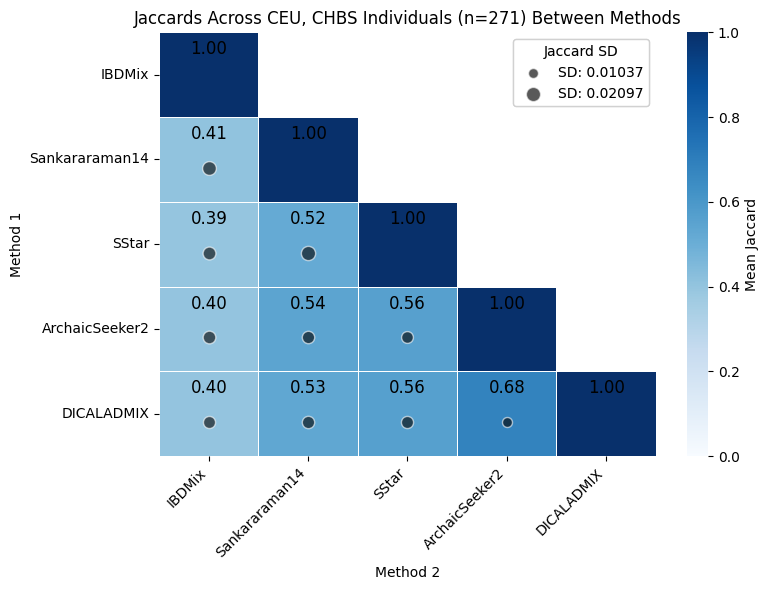

In [20]:
tools.individual_jaccard_comparison_dot_heatmap(
    heatmap_data=heatmap_data,
    tsv=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/ibdmix_archaicseeker2_dicaladmix_sstar_sankararaman14_min_subset_individual.tsv',
    title='Jaccards Across CEU, CHBS Individuals (n=271) Between Methods',
    color='Blues',
    save_plot_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/ibdmix_archaicseeker2_dicaladmix_sstar_sankararaman14_min_subset_individual.svg'
)

/scratch/ychen39/ipykernel_2202139/3504315171.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


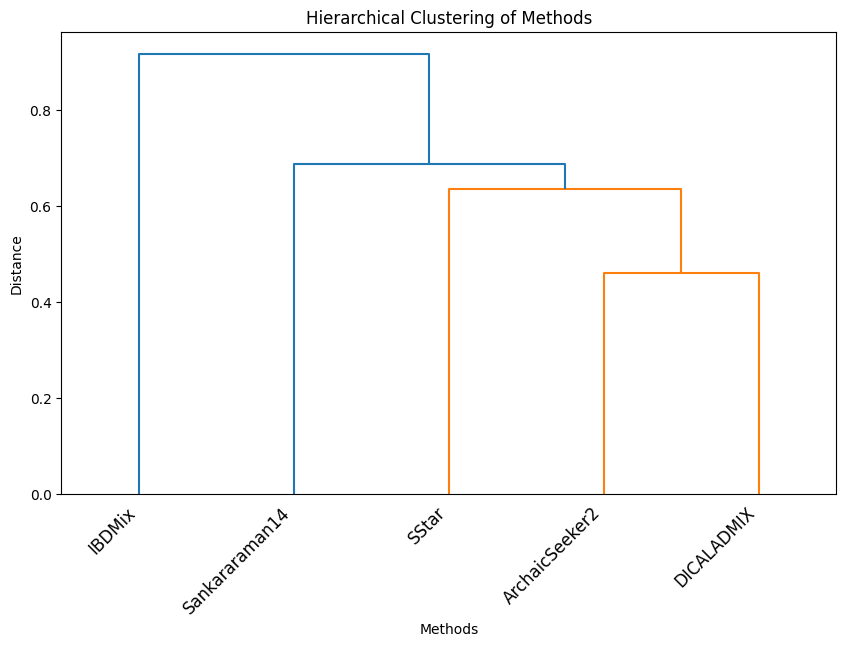

In [ ]:
df= pd.concat(heatmap_data).groupby(level=0).mean()

df_reordered = df.reindex(columns=df.columns, index=df.columns)

distance_matrix = 1 - df_reordered
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df_reordered.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
#pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/clustering.png', dpi=300, bbox_inches='tight')
plt.show()

### Other groupings: 1 SGDP individual, 228 SGDP individuals, African SGDP individuals (admixed and not-admixed)

### 1 SGDP Papuan individual

In [11]:
# read in all the data
SARGE_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/data/sarge_schaefer2021/sarge_admixed_haps_hs37d5.bed', sep='\t', low_memory=False)
SARGE_individual.rename(columns={'#chrom': 'Chromosome',
                                'start': 'Start',
                                'end': 'End',
                                'len': 'length',
                                'score': 'Score'}, inplace=True)

archaicseeker2_individual=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/yuan_2021/individual_nean_yuan2021_frag.bed', sep='\t', low_memory=False)
archaicseeker2_individual['ID'] = archaicseeker2_individual['ID'].str.split('_').str[0]

argweaverd_individual_papuan=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/hubisz_2020/papuan_individual_nean_hubisz2020_frag.bed', sep='\t', low_memory=False)
argweaverd_individual_khomani_san=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/hubisz_2020/khomani_san_individual_nean_hubisz2020_frag.bed', sep='\t', low_memory=False)
argweaverd_individual_mandenka=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/hubisz_2020/mandenka_individual_nean_hubisz2020_frag.bed', sep='\t', low_memory=False)
argweaverd_individual = pd.concat([argweaverd_individual_papuan, argweaverd_individual_khomani_san, argweaverd_individual_mandenka])

sankararaman16_1_individual=pd.read_csv(f"{HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_1/sgdp_individual_neanderthal_introgressed_fragments_pops.bed", sep='\t', low_memory=False)
sankararaman16_1_individual['ID'] = sankararaman16_1_individual['ID'].str.split('_').str[1].str.split('-').str[:2].str.join('-')
sankararaman16_2_individual=pd.read_csv(f"{HOMEDIR}/introgression_methods/cleaned/introgression_tools/sankararaman_2016_2/sgdp_individual_neanderthal_introgressed_fragments_pops.bed", sep='\t', low_memory=False)
sankararaman16_2_individual['ID'] = sankararaman16_2_individual['ID'].str.split('_').str[1].str.split('-').str[:2].str.join('-')

# make a dictionary to get from Illumina_ID to SGDP_ID
SGDP_metadata=pd.read_csv(f'{HOMEDIR}/introgression_methods/data/SGDP_metadata.279public.21signedLetter.44Fan.samples.txt', sep='\t', low_memory=False, encoding='unicode_escape')
SGDP_metadata_dict = dict(zip(SGDP_metadata.Illumina_ID, SGDP_metadata.SGDP_ID.str.split('_').str[1]))

argweaverd_individual['ID'] = argweaverd_individual['ID'].replace(SGDP_metadata_dict) # remap IDs
SARGE_individual['ID'] = SARGE_individual['hap'].str.split('_').str[1].str.split('-').str[:2].str.join('-') # create ID column by removing the prefix and the 2 chromosomes id at the end

In [18]:
# all sgdp: 1 papuan individual shared
archaicseeker2_argweaverd_sarge_sankararaman16_dict = {'SARGE':SARGE_individual, 
                                                       'ARGWeaver-D':argweaverd_individual,
                                                      'ArchaicSeeker2':archaicseeker2_individual,
                                                      'Sankararaman16_1':sankararaman16_1_individual,
                                                      'Sankararaman16_2':sankararaman16_2_individual}

# compute jaccards
heatmap_data=tools.individual_jaccard_comparison(dfs_dict = archaicseeker2_argweaverd_sarge_sankararaman16_dict,
                              temp_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/', 
                              output_jaccards_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/archaicseeker2_argweaverd_sarge_sankararaman16_jaccard.tsv',
                              return_heatmap=True,
                              autosomes_only=True,
                              x_only=False)

['SARGE', 'ARGWeaver-D', 'ArchaicSeeker2', 'Sankararaman16_1', 'Sankararaman16_2'] : 1 individuals shared,  ['Papuan-1']


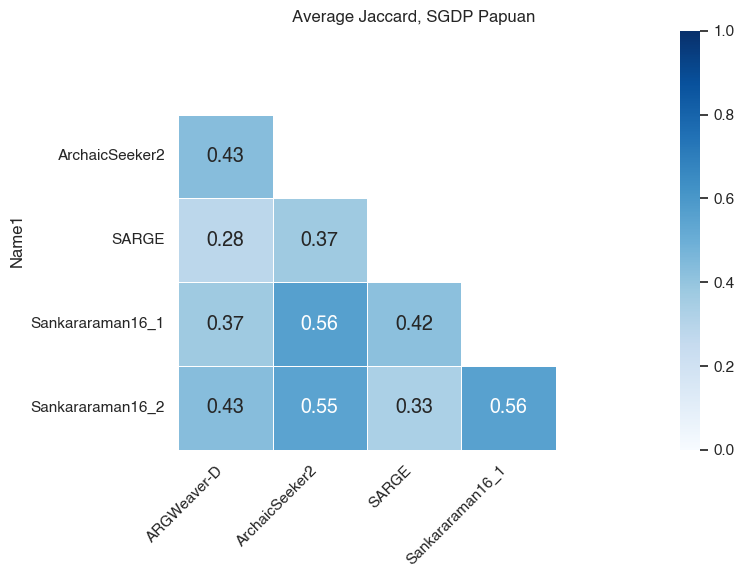

In [160]:
tools.individual_jaccard_comparison_heatmap(
    tsv=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/archaicseeker2_argweaverd_sarge_sankararaman16_jaccard.tsv',
    title='Average Jaccard, SGDP Papuan',
    color='Blues',
    save_plot_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/archaicseeker2_argweaverd_sarge_sankararaman16_jaccard.svg',
)

/tmp/ipykernel_3874757/3504315171.py:7: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete') # Options: 'single', 'complete', 'average', 'ward', etc.


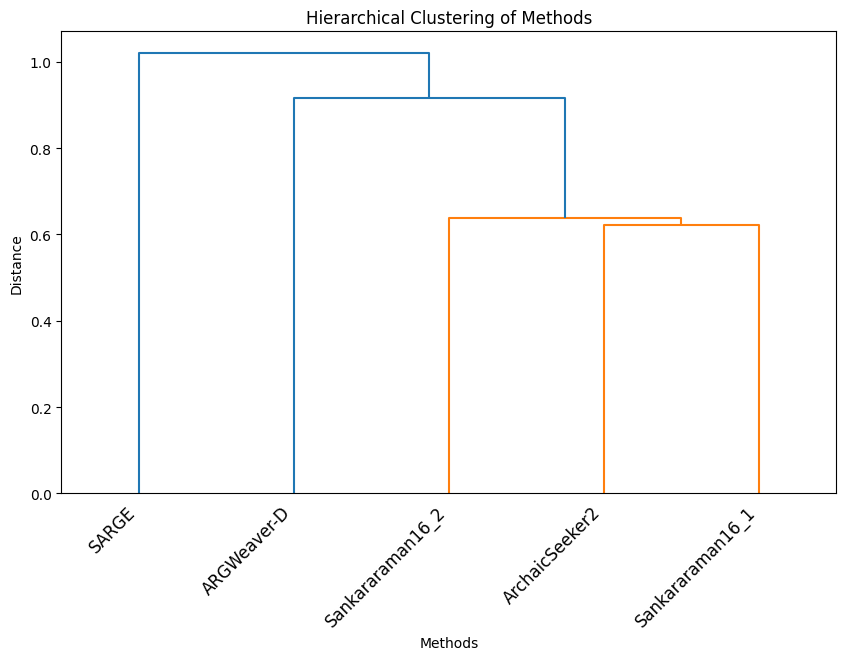

In [ ]:
df= pd.concat(heatmap_data).groupby(level=0).mean()

df_reordered = df.reindex(columns=df.columns, index=df.columns)

distance_matrix = 1 - df_reordered
# hierarchical clustering using complete linkage
Z = linkage(distance_matrix, method='complete')

leaf_order = leaves_list(Z)

plt.figure(figsize=(10, 6))
dendrogram(Z, labels=df_reordered.columns, orientation='top', leaf_rotation=90)
plt.title('Hierarchical Clustering of Methods')
plt.xlabel('Methods')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
#pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/clustering.png', dpi=300, bbox_inches='tight')
plt.show()

### 228 SGDP Individual

In [15]:
# sarge and sankararamans
sarge_sankararaman16_dict = {'SARGE':SARGE_individual, 
        'Sankararaman16_1':sankararaman16_1_individual,
        'Sankararaman16_2':sankararaman16_2_individual}

# compute jaccards
heatmap_data=tools.individual_jaccard_comparison(dfs_dict = sarge_sankararaman16_dict,
                              temp_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/tmp', 
                              output_jaccards_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/sarge_sankararaman16_jaccard.tsv',
                              return_heatmap=True)

['SARGE', 'Sankararaman16_1', 'Sankararaman16_2'] : 228 individuals shared,  ['Abkhasian-1', 'Abkhasian-2', 'Adygei-1', 'Adygei-2', 'Albanian-1', 'Aleut-1', 'Aleut-2', 'Altaian-1', 'Ami-1', 'Ami-2', 'Armenian-1', 'Armenian-2', 'Atayal-1', 'Australian-3', 'Australian-4', 'Balochi-1', 'Basque-1', 'Basque-2', 'BedouinB-1', 'BedouinB-2', 'Bengali-1', 'Bengali-2', 'Bergamo-1', 'Bergamo-2', 'Bougainville-1', 'Bougainville-2', 'Brahmin-1', 'Brahmin-2', 'Brahui-1', 'Brahui-2', 'Bulgarian-1', 'Bulgarian-2', 'Burmese-1', 'Burmese-2', 'Burusho-1', 'Burusho-2', 'Cambodian-1', 'Cambodian-2', 'Chane-1', 'Chechen-1', 'Chukchi-1', 'Crete-1', 'Crete-2', 'Czech-2', 'Dai-1', 'Dai-2', 'Dai-3', 'Dai-4', 'Daur-1', 'Daur-2', 'Druze-1', 'Druze-2', 'Dusun-1', 'Dusun-2', 'English-1', 'English-2', 'Eskimo', 'Estonian-1', 'Estonian-2', 'Even-1', 'Even-2', 'Even-3', 'Finnish-1', 'Finnish-2', 'Finnish-3', 'French-1', 'French-2', 'French-3', 'Georgian-1', 'Georgian-2', 'Greek-1', 'Greek-2', 'Han-1', 'Han-2', 'Han-3'

/wynton/home/capra/ychen39/introgression_methods/introgression_tools/introgression_tools/tools.py:2121: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


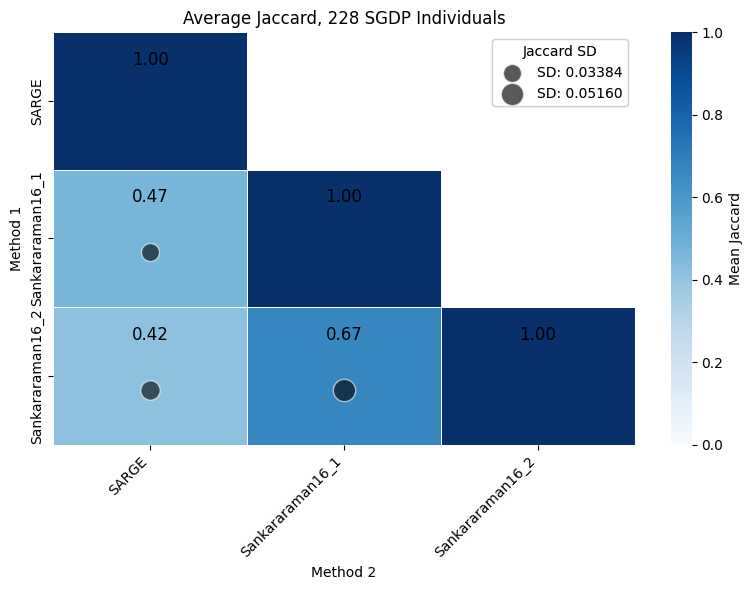

In [16]:
tools.individual_jaccard_comparison_dot_heatmap(
    heatmap_data=heatmap_data,
    tsv=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/sarge_sankararaman16_jaccard.tsv',
    title='Average Jaccard, 228 SGDP Individuals',
    color='Blues',
    save_plot_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/sarge_sankararaman16_jaccard.svg'
)

### 15 Papuan individuals - Violin plot

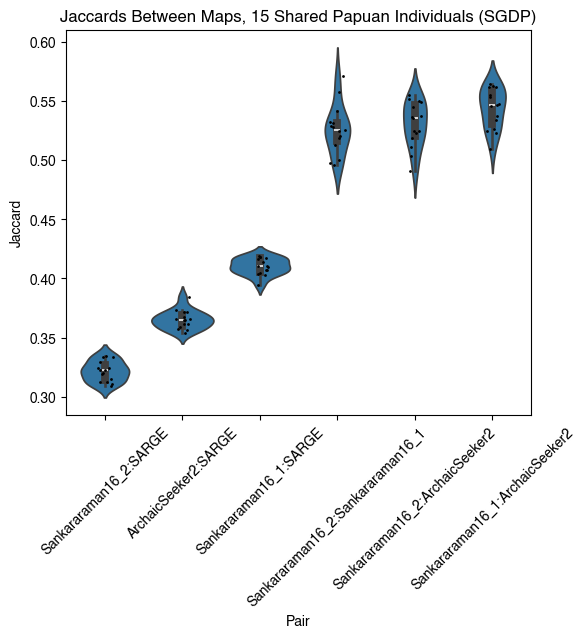

In [ ]:
# load precomputed jaccard data
sarge_archaicseeker2_sankararaman16_jaccard=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/individual_comparison/sarge_archaicseeker2_sankararaman16_jaccard.tsv', sep='\t', low_memory=False)

# calculate average values for each category
avg_values = sarge_archaicseeker2_sankararaman16_jaccard.groupby('Pair')['Jaccard'].mean().sort_values()

# order categories by average values
ordered_categories = avg_values.index

plt.figure(figsize=(6, 5))
sns.violinplot(data=sarge_archaicseeker2_sankararaman16_jaccard, x='Pair', y='Jaccard', order=ordered_categories)
# overlay strip plot with jitter
sns.stripplot(data=sarge_archaicseeker2_sankararaman16_jaccard, x='Pair', y='Jaccard', jitter=True, color='black', size=2, order=ordered_categories)

plt.xticks(rotation=45)
plt.title('Jaccards Between Maps, 15 Shared Papuan Individuals (SGDP)')

pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/15_shared_papuan.svg', bbox_inches='tight')
plt.show()

### African individuals (including admixed individuals)

In [6]:
# create overlap file
tools.combine_pop_files([f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/merged_Africa.bg', 
                   f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/bedgraphs/merged_Africa2.bg'],
                   output_dir=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/',
                   output_file='african_introgressed.bed')

african_boolean_overlap = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/bedgraphs/merged_AFR.bg \
                                                                {HOMEDIR}/introgression_methods/cleaned/introgression_tools/hubisz_2020/bedgraphs/merged_Africa.bg \
                                                                {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/african_introgressed.bg',
                                           input_files_names_str='IBDMix ARGweaver-D SARGE',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/african_overlap.bed',
                                           boolean=True, autosomes=True)
african_boolean_overlap

,chrom,start,end,IBDMix,ARGweaver-D,SARGE,length
0,1,931494,939444,False,False,True,7950
1,1,1094166,1119404,False,False,True,25238
2,1,1176836,1190335,False,False,True,13499
3,1,1709378,1770619,False,False,True,61241
4,1,2301732,2324401,False,False,True,22669
...,...,...,...,...,...,...,...
37678,9,139868913,139879791,False,False,True,10878
37679,9,140298135,140303914,False,False,True,5779
37680,9,140458739,140465483,False,False,True,6744
37681,9,140594543,140604939,False,False,True,10396


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

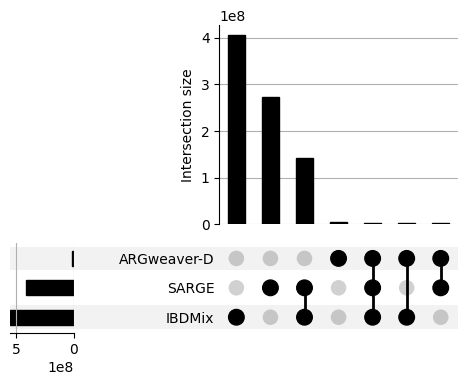

In [8]:
african_boolean_overlap_upset=african_boolean_overlap.drop(['chrom', 'start', 'end'], axis=1)
plot(from_indicators(['IBDMix', 'ARGweaver-D', 'SARGE'], data=african_boolean_overlap_upset), sum_over="length", subset_size="sum", sort_by="cardinality")

save


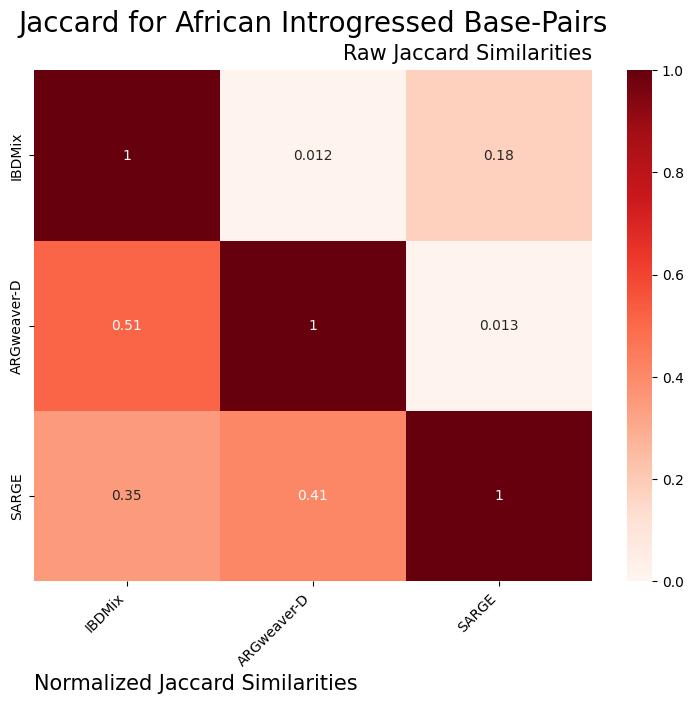

,IBDMix,ARGweaver-D,SARGE
IBDMix,1.0,0.012486,0.176269
ARGweaver-D,0.012486,1.0,0.013022
SARGE,0.176269,0.013022,1.0


In [9]:
tools.plot_jaccard(boolean_df=african_boolean_overlap,
             categories_list=['IBDMix', 'ARGweaver-D', 'SARGE'],
             value_column='length',
             type='combined',
             color='Reds',
             combined_title = 'Jaccard for African Introgressed Base-Pairs',
             save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/AFR_sarge_ibdmix_argweaverd_admixed.svg')

### African individuals - no admixed

In [10]:
# create overlap file again without AFR admixed individuals from IBDMix

african_boolean_overlap_no_admix = tools.generate_overlap(input_files_string=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/chen_2020/AFR_no_admixed.bg \
                                                                {HOMEDIR}/introgression_methods/cleaned/introgression_tools/hubisz_2020/bedgraphs/merged_Africa.bg \
                                                                {HOMEDIR}/introgression_methods/cleaned/introgression_tools/schaefer_2021/african_introgressed.bg',
                                           input_files_names_str='IBDMix ARGweaver-D SARGE',
                                           output_file_path=f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/african_boolean_overlap_no_admix.bed',
                                           boolean=True, autosomes=True)
african_boolean_overlap_no_admix

,chrom,start,end,IBDMix,ARGweaver-D,SARGE,length
0,1,931494,939444,False,False,True,7950
1,1,1094166,1119404,False,False,True,25238
2,1,1176836,1190335,False,False,True,13499
3,1,1709378,1770619,False,False,True,61241
4,1,2301732,2324401,False,False,True,22669
...,...,...,...,...,...,...,...
33190,9,139868913,139879791,False,False,True,10878
33191,9,140298135,140303914,False,False,True,5779
33192,9,140458739,140465483,False,False,True,6744
33193,9,140594543,140604939,False,False,True,10396


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

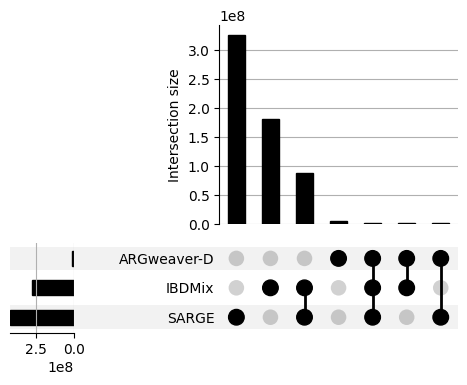

In [11]:
african_boolean_overlap_no_admix=african_boolean_overlap_no_admix.drop(['chrom', 'start', 'end'], axis=1)
plot(from_indicators(['IBDMix', 'ARGweaver-D', 'SARGE'], data=african_boolean_overlap_no_admix), sum_over="length", subset_size="sum", sort_by="cardinality")


save


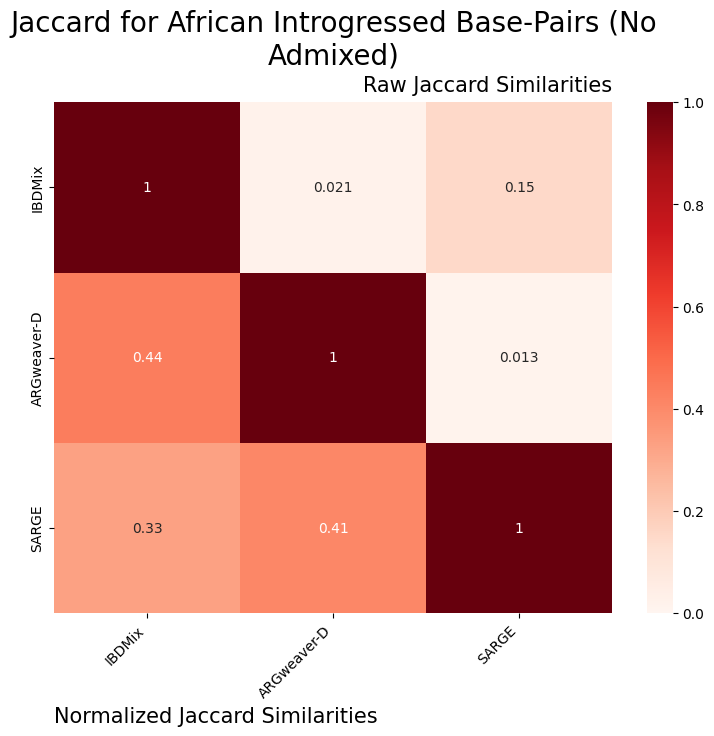

,IBDMix,ARGweaver-D,SARGE
IBDMix,1.0,0.021187,0.150952
ARGweaver-D,0.021187,1.0,0.013022
SARGE,0.150952,0.013022,1.0


In [14]:
tools.plot_jaccard(boolean_df=african_boolean_overlap_no_admix,
             categories_list=['IBDMix', 'ARGweaver-D', 'SARGE'],
             value_column='length',
             type='combined',
             combined_title = 'Jaccard for African Introgressed Base-Pairs (No Admixed)',
             save_fig_path=f'{HOMEDIR}/introgression_methods/figures/introgression_tools/individual_comparison/figures/AFR_sarge_ibdmix_argweaverd.svg')

## Deserts

#### Count number of fully supported regions

In [ ]:
# load in deserts
all_deserts = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/all_deserts.bed', sep='\t')

# replace 0s with NA, drop rows with NA
overlap_all_methods = all_deserts.replace(0, np.nan)
overlap_all_methods = all_deserts.dropna()
# separate bed only
overlap_all_methods_bed = overlap_all_methods[['chrom', 'start', 'end']]
# add 'chr' prefix
overlap_all_methods_bed['chrom']='chr'+overlap_all_methods_bed['chrom']

#overlap_all_methods_bed.to_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts_all_methods_overlap.bed', sep='\t', index=False, header=False)

,chrom,start,end
227,chr3,78049151,79049150
229,chr3,80049150,84049151
321,chr7,106640445,107640445
323,chr7,110640056,113640055
325,chr7,116640054,123200000
346,chr8,54912560,55912560
348,chr8,56912559,57912559
350,chr8,58912559,64912557


#### Number of desert regions supported by 3 or 4 regions

In [ ]:
# load in deserts
all_deserts = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/all_deserts.bed', sep='\t')
# count methods supporting for each region
all_deserts['total'] = all_deserts['sankararaman_2016_1'] + all_deserts['skov_2020'] + all_deserts['chen_2020'] + all_deserts['vernot_2016'] + all_deserts['yuan_2021']

In [ ]:
# num regions supported by 4 methods
print(len(all_deserts[(all_deserts['total']==4)]))
# show the regions
all_deserts[(all_deserts['total']==4)]

13


,chrom,start,end,sankararaman_2016_1,skov_2020,chen_2020,vernot_2016,yuan_2021,total
26,1,105542622,109542622,1,1,1,1,0,4
28,1,110542622,114542622,1,1,1,1,0,4
226,3,77000000,78049151,1,0,1,1,1,4
228,3,79049150,80049150,1,0,1,1,1,4
230,3,84049151,89300000,1,0,1,1,1,4
320,7,106300000,106640445,1,0,1,1,1,4
322,7,107640445,110640056,1,0,1,1,1,4
324,7,113640055,116640054,1,0,1,1,1,4
326,7,123200000,124640054,1,1,0,1,1,4
345,8,54000000,54912560,1,0,1,1,1,4


In [ ]:
# num regions supported by 3 methods
print(len(all_deserts[(all_deserts['total']==3)]))
# show the regions
all_deserts[(all_deserts['total']==3)]

# chr7:113,725,827–114,330,480 - FOXP2
# chr3:75,955,827-77,699,115 - ROBO2

23


,chrom,start,end,sankararaman_2016_1,skov_2020,chen_2020,vernot_2016,yuan_2021,total
23,1,102465556,104542622,1,1,0,1,0,3
25,1,105400000,105542622,1,0,1,1,0,3
27,1,109542622,110542622,1,0,1,1,0,3
29,1,114542622,114900000,1,0,1,1,0,3
55,10,99759757,102759757,1,1,0,0,1,3
57,10,104759757,105759758,1,1,0,0,1,3
59,10,106759758,107759758,1,1,0,0,1,3
108,16,11093857,12093857,1,1,0,0,1,3
110,16,15093857,16093857,1,1,0,0,1,3
132,17,39156252,42077368,1,1,0,0,1,3


In [ ]:
# save regions supported by at least 3 methods
all_deserts['total'] = all_deserts['sankararaman_2016_1'] + all_deserts['skov_2020'] + all_deserts['chen_2020'] + all_deserts['vernot_2016'] + all_deserts['yuan_2021']
# subset regions supported by at least 3 methods
deserts_3_more_support = all_deserts[(all_deserts['total']>=3)]
deserts_3_more_support['chrom']='chr' + deserts_3_more_support['chrom']
# save to csv
deserts_3_more_support[['chrom', 'start', 'end']].to_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts_3_or_more_methods_overlap.bed', sep='\t', index=False, header=False)

#### Plot introgression proportion in deserts

In [ ]:
# generate combined dataframe

sankararaman_2016_introgression_in_deserts=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts/sankararaman_2016_introgression_in_deserts', sep='\t', low_memory=False,
                                       names=["chrom", "start", "end", "num_introgression_regions_overlapping_desert_regions", "num_bases_not_introgressed_but_deserts", "length_desert", "fraction_introgression_overlapping_deserts", 'introgression_dir'])

vernot_2016_introgression_in_deserts=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts/vernot_2016_introgression_in_deserts', sep='\t', low_memory=False,
                                       names=["chrom", "start", "end", "num_introgression_regions_overlapping_desert_regions", "num_bases_not_introgressed_but_deserts", "length_desert", "fraction_introgression_overlapping_deserts", 'introgression_dir'])

skov_2020_introgression_in_deserts=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts/skov_2020_introgression_in_deserts', sep='\t', low_memory=False,
                                       names=["chrom", "start", "end", "num_introgression_regions_overlapping_desert_regions", "num_bases_not_introgressed_but_deserts", "length_desert", "fraction_introgression_overlapping_deserts", 'introgression_dir'])

chen_2020_introgression_in_deserts=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts/chen_2020_introgression_in_deserts', sep='\t', low_memory=False,
                                       names=["chrom", "start", "end", "num_introgression_regions_overlapping_desert_regions", "num_bases_not_introgressed_but_deserts", "length_desert", "fraction_introgression_overlapping_deserts", 'introgression_dir'])

yuan_2021_introgression_in_deserts=pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/deserts/yuan_2021_introgression_in_deserts', sep='\t', low_memory=False,
                                       names=["chrom", "start", "end", "num_introgression_regions_overlapping_desert_regions", "num_bases_not_introgressed_but_deserts", "length_desert", "fraction_introgression_overlapping_deserts", 'introgression_dir'])


# combined dataframe
combined_introgression_in_deserts = pd.concat([sankararaman_2016_introgression_in_deserts, vernot_2016_introgression_in_deserts, 
          skov_2020_introgression_in_deserts, chen_2020_introgression_in_deserts, yuan_2021_introgression_in_deserts], axis=0,
          keys=['Sankararaman16', 'S*', 'Skov20', 'IBDMix', 'ArchaicSeeker2']).reset_index()

combined_introgression_in_deserts['introgression_dir']= combined_introgression_in_deserts['introgression_dir'].map({'chen_2020': 'IBDMix', 'hubisz_2020': 'ARGweaver-D', 'yuan_2021': 'ArchaicSeeker2', 'durvasula_2019': 'ArchIE',
                                   'browning_2018': 'Sprime', 'schaefer_2021': 'SARGE', 'vernot_2016':'S*', 'sankararaman_2014': 'Sankararaman14',
                                 'sankararaman_2016_1':'Sankararaman16 (1)', 'sankararaman_2016_2':'Sankararaman16 (2)', 'skov_2020':'Skov20',
                                 'steinruecken_2018':'DICAL-ADMIX'})

combined_introgression_in_deserts

,level_0,level_1,chrom,start,end,num_introgression_regions_overlapping_desert_regions,num_bases_not_introgressed_but_deserts,length_desert,fraction_introgression_overlapping_deserts,introgression_dir
0,Sankararaman16,0,1,62000000,76000000,16,1839939,14000000,0.131424,Sprime
1,Sankararaman16,1,1,87000000,98000000,14,2674842,11000000,0.243168,Sprime
2,Sankararaman16,2,1,99000000,115000000,13,1391550,16000000,0.086972,Sprime
3,Sankararaman16,3,2,15000000,28000000,13,2428639,13000000,0.186818,Sprime
4,Sankararaman16,4,2,199000000,212000000,9,1452661,13000000,0.111743,Sprime
...,...,...,...,...,...,...,...,...,...,...
3799,ArchaicSeeker2,67,7,105214808,125414808,81,1027133,20200000,0.050848,ArchaicSeeker2
3800,ArchaicSeeker2,68,8,52811740,66011740,97,1150271,13200000,0.087142,ArchaicSeeker2
3801,ArchaicSeeker2,69,10,99260494,109560494,51,1160001,10300000,0.112621,ArchaicSeeker2
3802,ArchaicSeeker2,70,16,9760086,19860086,149,1975075,10100000,0.195552,ArchaicSeeker2


In [19]:
# count of deserts regions and lengths
methods = ['sankararaman_2016_1', 'skov_2020', 'chen_2020', 'vernot_2016', 'yuan_2021']

for method in methods:
    deserts = pd.read_csv(f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}/original_deserts.bg', sep='\t', names=['chrom', 'start', 'end'])
    deserts['length'] = deserts['end'] - deserts['start']
    print(f'{method}:', len(deserts), 'deserts,', np.sum(deserts['length'])/1000000, 'Mb')

sankararaman_2016_1: 33 deserts, 483.0 Mb
skov_2020: 268 deserts, 539.292803 Mb
chen_2020: 4 deserts, 64.5 Mb
vernot_2016: 6 deserts, 84.4 Mb
yuan_2021: 6 deserts, 79.1 Mb


#### Also plot the normalized proportion of introgression in each desert

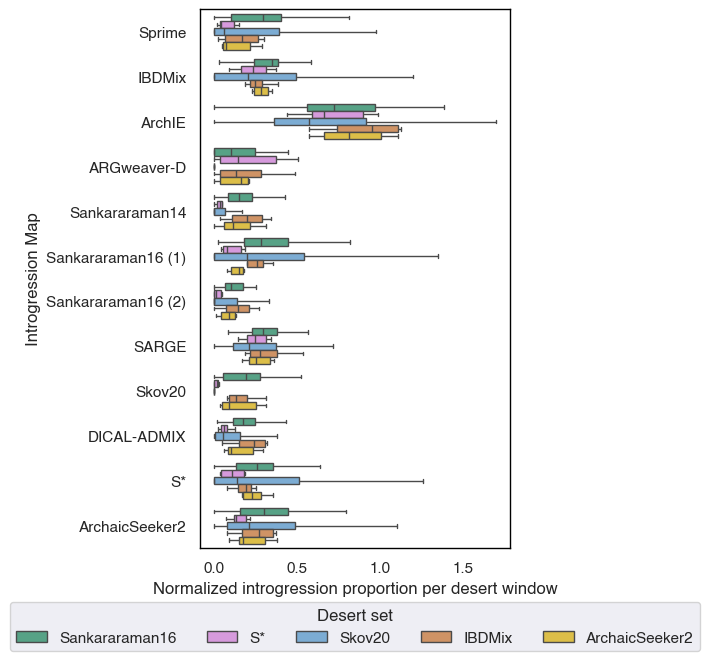

In [ ]:
combined_introgression_in_deserts['fraction_introgression'] = combined_introgression_in_deserts['introgression_dir'].map(coverage_dict)

combined_introgression_in_deserts['fraction_introgression_overlapping_deserts_normalized_introgression'] = combined_introgression_in_deserts['fraction_introgression_overlapping_deserts'] / combined_introgression_in_deserts['fraction_introgression']

## combined
sns.set_style("white")
sns.set(font="Helvetica")
fig, ax = plt.subplots(figsize=(4,7))

sns.boxplot(
    data=combined_introgression_in_deserts,
    hue='level_0',
    palette=["#4AAE8A", "#DF8FE7", "#6daee2", "#e19153", "#f4cd30"],
    x='fraction_introgression_overlapping_deserts_normalized_introgression',
    y='introgression_dir',
    showfliers=False,
    orient='h',
    ax=ax
)

# put the legend out of the figure
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title='Desert set',
    bbox_to_anchor=(0.5, -0.1),
    loc='upper center',
    borderaxespad=0.,
    ncol=len(handles)
)

# axis labels
ax.set_xlabel("Normalized introgression proportion per desert window")
ax.set_ylabel("Introgression Map")

# remove background in plot and legends
ax.set_facecolor("none")
fig.patch.set_facecolor("none")

# add borders
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1)

# removed strip plot because the outliers mess up the y axis

plt.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/norm_combined_desert_introgression.svg', bbox_inches='tight')

plt.show()

# Intersect each introgression map with B statistic scores from McVicker et al

To estimate the strength of background selection experienced by human genomic loci, B statistic values ranging on a scale from 1–1,000 were downloaded at http://www.phrap.org/software_dir/mcvicker_dir/bkgd.tar.gz. We quantized these values by rounding them down to the nearest multiple of 50 B statistic units, then lifted them over from hg18 coordinates to hg19 coordinates. Each SNP in the SGDP data was assigned the B statistic value of the closest site annotated by McVicker et al.28.

The phrap link does not work, but the data is provided in https://github.com/kelleyharris/hominin-enhancers/tree/master/bkgd.

Let's use this data (hg19_Bstats_bin50_chrom*.bed, uploaded to data/background_selection_mcvicker_harris/)

`scp -r hg19_Bstats_bin50_chrom*.bed ychen39@dt2.wynton.ucsf.edu:/wynton/home/capra/ychen39/introgression_methods/data/background_selection_mcvicker_harris`

In [25]:
%%bash 

HOMEDIR='/wynton/home/capra/ychen39/'

output=${HOMEDIR}/introgression_methods/data/background_selection_mcvicker_harris/merged_bstats_hg19.bed

for file in ${HOMEDIR}/introgression_methods/data/background_selection_mcvicker_harris/hg19*.bed; do
    # get chrom and add to the output file as the first column, then the rest of the data
    chrom_name=$(echo "$file" | sed -n 's/.*hg19_Bstats_bin50_chrom\(.*\)\.bed/\1/p')
    echo $chrom_name

    awk -v chrom="$chrom_name" '{print chrom, $0}' OFS="\t" "$file" >> "$output"
done

10
11
12
13
14
15
16
17
18
19
1
20
21
22
2
3
4
5
6
7
8
9


In [ ]:
# intersect each introgression map with bedtools.
# read in b statistic information_
b_stat = pd.read_csv(f'{HOMEDIR}/introgression_methods/data/background_selection_mcvicker_harris/merged_bstats_hg19.bed', sep='\t', names=['chrom', 'start', 'end', 'b_stat'])
b_stat_bed = pybedtools.BedTool.from_dataframe(b_stat)
b_stat_bed = b_stat_bed.sort()

# empty dict to hold average scores
intro_b_stat_average = {}
non_intro_b_stat_average = {}
final_b_stat_raw = {}

# set methods directories
methods_dirs = ['chen_2020', 'yuan_2021', 'durvasula_2019', 'steinruecken_2018', 'skov_2020', 'schaefer_2021', 'hubisz_2020', 'browning_2018', 'vernot_2016', 'sankararaman_2014', 'sankararaman_2016_1', 'sankararaman_2016_2']
# Use bedtools complement to get the non-introgressed regions for each method
for method in methods_dirs:
    if 'sankararaman' in method:
        method_name = method.replace('_', '', 1)
    else:
        method_name = method.replace('_', '')
    # specify method dir
    method_dir = f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}'
    print(method_dir)
    
    # read in introgression map
    introgression_map = pd.read_csv(f'{method_dir}/bedgraphs/union_merged_highest_score.bg', sep='\s+', usecols=[0, 1, 2])
    non_introgressed_map = pd.read_csv(f'{method_dir}/complement.bg', sep='\s+', usecols=[0, 1, 2], names=['chrom', 'start', 'end'])
    # remove chr prefix
    non_introgressed_map['chrom'] = non_introgressed_map['chrom'].str.replace('chr', '')
    
    # convert to BedTool object for pybedtools
    map_bed = pybedtools.BedTool.from_dataframe(introgression_map)
    non_intro_map_bed = pybedtools.BedTool.from_dataframe(non_introgressed_map)
    map_bed = map_bed.sort()
    non_intro_map_bed = non_intro_map_bed.sort()

    # intersect the two objects
    map_bstat_intersect = b_stat_bed.intersect(map_bed, wb=True)
    non_intro_map_bstat_intersect = b_stat_bed.intersect(non_intro_map_bed, wb=True)

    # drop extra columns (keep the scores and their positions that fall in map regions)
    intro_intersection = map_bstat_intersect.to_dataframe().drop(['score', 'strand', 'thickStart'], axis=1)
    non_intro_intersection = non_intro_map_bstat_intersect.to_dataframe().drop(['score', 'strand', 'thickStart'], axis=1)
    
    intro_intersection['length'] = intro_intersection['end'] - intro_intersection['start']
    non_intro_intersection['length'] = non_intro_intersection['end'] - non_intro_intersection['start']
    
    intro_score = np.sum(intro_intersection['length'] * intro_intersection['name']) / intro_intersection['length'].sum()
    non_intro_score = np.sum(non_intro_intersection['length'] * non_intro_intersection['name']) / non_intro_intersection['length'].sum()
    
    intro_b_stat_average[f'{method}'] = intro_score
    non_intro_b_stat_average[f'{method}'] = non_intro_score

/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/chen_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/yuan_2021
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/durvasula_2019
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/steinruecken_2018
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/skov_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/schaefer_2021
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/hubisz_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/browning_2018
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/vernot_2016
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/sankararaman_2014
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/sankarara

## Try with 500 bp windows

In [ ]:
# Make bed file with 500 bp bins across the hg19 genome

# empty dict to hold scores
intro_b_stat = {}
non_intro_b_stat = {}
intro_b_stat_smaller_than_window = {}
non_intro_b_stat_smaller_than_window = {}

# parameters: window size
window = 500

# read in b statistic information_
b_stat = pd.read_csv(f'{HOMEDIR}/introgression_methods/data/background_selection_mcvicker_harris/merged_bstats_hg19.bed', sep='\t', names=['chrom', 'start', 'end', 'b_stat'])
b_stat_bed = pybedtools.BedTool.from_dataframe(b_stat)
b_stat_bed = b_stat_bed.sort()

# set methods directories
methods_dirs = ['chen_2020', 'yuan_2021', 'durvasula_2019', 'steinruecken_2018', 'skov_2020', 'schaefer_2021', 'hubisz_2020', 'browning_2018', 'vernot_2016', 'sankararaman_2014', 'sankararaman_2016_1', 'sankararaman_2016_2']
# Use bedtools complement to get the non-introgressed regions for each method
for method in methods_dirs:
    if 'sankararaman' in method:
        method_name = method.replace('_', '', 1)
    else:
        method_name = method.replace('_', '')
    # specify method dir
    method_dir = f'{HOMEDIR}/introgression_methods/cleaned/introgression_tools/{method}'
    print(method_dir)
    
    # read in introgression map
    introgression_map = pd.read_csv(f'{method_dir}/bedgraphs/union_merged_highest_score.bg', sep='\s+', usecols=[0, 1, 2])
    
    # convert to BedTool object for pybedtools
    map_bed = pybedtools.BedTool.from_dataframe(introgression_map)
    map_bed = map_bed.sort()

    # make genome-wide window file to assign windows to the introgression map
    hg19_5kb = pybedtools.BedTool().window_maker(b='/wynton/home/capra/ychen39/introgression_methods/data/human_hg19_gaps_removed_common_chr.bed', w=window)
    # remove chr prefix
    hg19_5kb_df = hg19_5kb.to_dataframe()
    hg19_5kb_df['chrom'] = hg19_5kb_df['chrom'].str.replace('^chr', '', regex=True)
    # convert back to bedtools
    hg19_5kb = pybedtools.BedTool.from_dataframe(hg19_5kb_df)

    # intersect B statistic scores, computing the average for each window entry
    map_windows_intersect = hg19_5kb.intersect(map_bed, wao=True) #u: write original entry A (b stats if at least 1 base pair overlaps)

    # Get introgressed (at least 1 base pair of the window is introgressed) and non-introgressed (no windows fall in non-introgressed regions)
    map_windows_intersect_df = map_windows_intersect.to_dataframe(low_memory=False)
    introgressed = pybedtools.BedTool.from_dataframe(map_windows_intersect_df[map_windows_intersect_df['score'] > 0][['chrom', 'start', 'end']]) # convert to bedtools object
    non_introgressed = pybedtools.BedTool.from_dataframe(map_windows_intersect_df[map_windows_intersect_df['score'] == -1][['chrom', 'start', 'end']])

    # for introgressed and non introgressed windows, compute average B statistic for each 5kb window
    # remove intersections that are less than 5 kb
    # introgrssed
    intro_b_stat_intersect = introgressed.intersect(b_stat_bed, wo=True)
    intro_b_stat_intersect = intro_b_stat_intersect.to_dataframe()
    intro_b_stat_intersect = intro_b_stat_intersect.drop_duplicates()
    intro_b_stat[method] = intro_b_stat_intersect['thickStart'][intro_b_stat_intersect['thickEnd'] == window]
    # for regions smaller than the window, add the sum of their scores*length to a separate dict
    # thickStart is the score, thickEnd is the size of the intersection
    intro_b_stat_smaller_than_window[method] = np.sum(intro_b_stat_intersect['thickStart']*intro_b_stat_intersect['thickEnd'][intro_b_stat_intersect['thickEnd'] <= window])

    # nonintrogressed
    non_intro_b_stat_intersect = non_introgressed.intersect(b_stat_bed, wo=True)
    non_intro_b_stat_intersect = non_intro_b_stat_intersect.to_dataframe()
    non_intro_b_stat_intersect = non_intro_b_stat_intersect.drop_duplicates()
    non_intro_b_stat[method] = non_intro_b_stat_intersect['thickStart'][non_intro_b_stat_intersect['thickEnd'] == window]
    non_intro_b_stat_smaller_than_window[method] = np.sum(non_intro_b_stat_intersect['thickStart']*non_intro_b_stat_intersect['thickEnd'][non_intro_b_stat_intersect['thickEnd'] <= window])

#PLOT: convert dict to datafrmae
non_intro_b_stat_df = pd.DataFrame(non_intro_b_stat)
intro_b_stat_df = pd.DataFrame(intro_b_stat)

# rename
nonintro = non_intro_b_stat_df.melt(var_name='Feature', value_name='Value')
nonintro['Source'] = 'Non-Introgressed'

intro = intro_b_stat_df.melt(var_name='Feature', value_name='Value')
intro['Source'] = 'Introgressed'

# combine both into one DataFrame, remove NAs (NA means there weren't enough windows to match the other maps)
combined = pd.concat([nonintro, intro], ignore_index=True).dropna(axis=0)

# rename
combined['Feature'] = combined['Feature'].map(rename_dict_dir)

/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/chen_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/yuan_2021
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/durvasula_2019
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/steinruecken_2018
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/skov_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/schaefer_2021
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/hubisz_2020
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/browning_2018
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/vernot_2016
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/sankararaman_2014
/wynton/home/capra/ychen39//introgression_methods/cleaned/introgression_tools/sankarara

In [ ]:
# save to a pickle file
with open(f'{HOMEDIR}/introgression_methods/data/bstat_by_map_500bp.pkl', 'wb') as f:
    pickle.dump(combined, f)

In [21]:
with open(f'{HOMEDIR}/introgression_methods/data/bstat_by_map_500bp.pkl', 'rb') as f:
    combined = pickle.load(f)

In [68]:
combined

,Feature,Value,Source
0,IBDMix,850.0,Non-Introgressed
1,IBDMix,850.0,Non-Introgressed
2,IBDMix,850.0,Non-Introgressed
3,IBDMix,850.0,Non-Introgressed
4,IBDMix,850.0,Non-Introgressed
...,...,...,...
96274731,Sankararaman16 (2),900.0,Introgressed
96274732,Sankararaman16 (2),900.0,Introgressed
96274734,Sankararaman16 (2),900.0,Introgressed
96274735,Sankararaman16 (2),900.0,Introgressed


### Bootstrap values: see bootstrap_bstat_dist.py

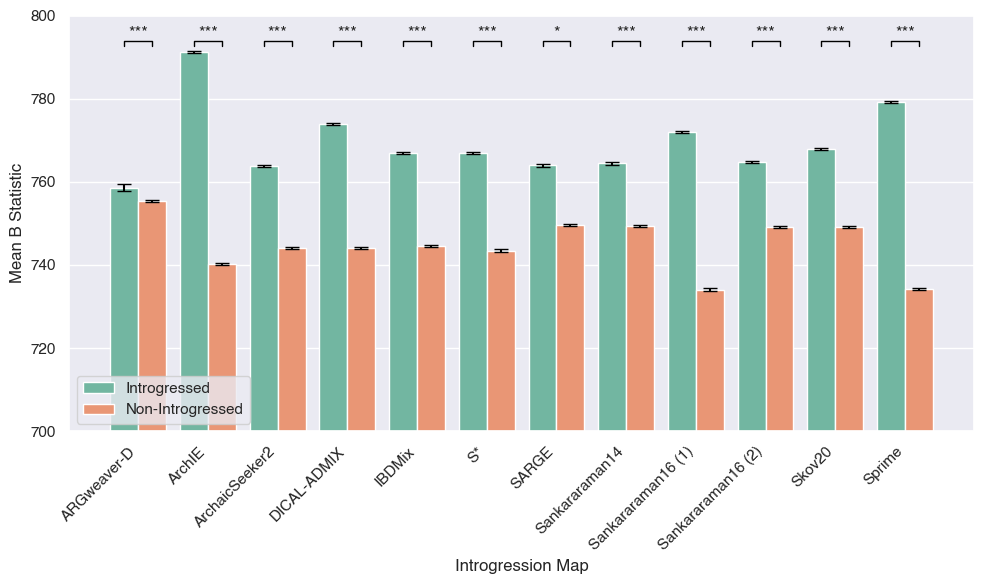

In [22]:
# read in output file
ci_df = pd.read_csv(f'{HOMEDIR}/introgression_methods/data/bstat_by_map_500bp_bootstrapped.tsv', sep='\t', names=['Feature', 'Source', 'Mean', 'CI_lower', 'CI_upper'])

# plot results
plt.figure(figsize=(10, 6))
sns.barplot(
    data=ci_df,
    x="Feature",
    y="Mean",
    hue="Source",
    capsize=0.1,
    palette="Set2"
)

# add error bars
for i, row in ci_df.iterrows():
    x = list(ci_df["Feature"].unique()).index(row["Feature"])
    offset = -0.2 if row["Source"] == ci_df["Source"].unique()[0] else 0.2
    plt.errorbar(
        x + offset,
        row["Mean"],
        yerr=[[row["Mean"] - row["CI_lower"]], [row["CI_upper"] - row["Mean"]]],
        fmt='none',
        c='black',
        capsize=5
    )

# significance asterisk function
def get_asterisks(p):
    if p <= 0.001:
        return '***'
    elif p <= 0.01:
        return '**'
    elif p <= 0.05:
        return '*'
    else:
        return 'ns'

# rank-sum test per feature
features = combined['Feature'].unique()
y_max = ci_df['CI_upper'].max()
y_min = ci_df['CI_upper'].min()
y_range = y_max - y_min
y_offset = 0.02 * y_range  # vertical space for line and asterisk

# save p values
pval_results = pd.DataFrame(columns=["map", "statistic", "p_value"])

for i, feature in enumerate(features):
    group1 = combined[(combined['Feature'] == feature) & (combined['Source'] == 'Introgressed')]['Value']
    group2 = combined[(combined['Feature'] == feature) & (combined['Source'] == 'Non-Introgressed')]['Value']

    if len(group1) > 0 and len(group2) > 0:
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        # add to df
        pval_results.loc[len(pval_results)] = [feature, stat, p]
        asterisk = get_asterisks(p)
        
        # bar positions
        x1 = i - 0.2
        x2 = i + 0.2
        y = y_max + y_offset 

        # Draw line betwene bars
        plt.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], color='black', linewidth=1)

        # add asterisk above line
        plt.text((x1 + x2) / 2, y + y_offset + 0.005 * y_range, asterisk,
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(700, 800)
plt.legend(title='')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Introgression Map")
plt.ylabel("Mean B Statistic")
plt.tight_layout()
pyplot.savefig(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/bstatscores/bstatscores_bootstrap.svg', bbox_inches='tight')
plt.show()



In [ ]:
pval_results['p_value'] = pval_results['p_value'].apply(lambda x: f"{x:.2e}") # convert to scientific notation.
pval_results.to_csv(f'{HOMEDIR}/introgression_methods/figures/introgression_tools/bstatscores/pval_bstat.tsv', sep='\t')